# AE-LSTM-CNN for CICIoT2023 Intrusion Detection
## Hardware-Optimized Architecture with Peak GPU Utilization (Linux/WSL Optimized)

This notebook implements an Autoencoder-LSTM-CNN hybrid architecture for intrusion detection on the CICIoT2023 dataset.

### Architecture Overview:
1. **Autoencoder**: Dimensionality reduction and feature extraction
2. **LSTM**: Temporal pattern recognition (Bidirectional)
3. **CNN**: Local feature extraction
4. **Classification Head**: Multi-class attack detection

### GPU Optimization Strategy (LINUX/WSL):
- **Large Batch Size**: 20480 samples to saturate GPU compute
- **Background File Prefetching**: CPU loads files while GPU trains (eliminates I/O bottleneck)
- **VRAM Caching**: Intelligently caches data on GPU when possible (~4.5GB)
- **Multi-worker Data Loading**: 4 workers with fork() method (Linux advantage)
- **Pinned Memory**: Zero-copy CPU→GPU transfer for ~2x faster data movement
- **Prefetching**: 4 batches loaded ahead to eliminate GPU stalls
- **Persistent Workers**: Workers stay alive between chunks (no restart overhead)
- **Non-blocking Transfers**: CPU preprocessing overlaps with GPU compute
- **Larger Chunks**: 500K rows for better file I/O efficiency
- **cuDNN Autotuner**: Optimal convolution algorithms
- **TF32 Operations**: Faster matrix multiplications on modern GPUs
- **Gradient Clipping**: Improved training stability
- **Mixed Precision (FP16)**: 2x throughput with minimal accuracy loss
- **OOM Protection**: Graceful handling of out-of-memory situations

### Memory Management:
- **File-by-file streaming** for RAM efficiency
- **Chunk-based processing** to stay within system RAM limits
- **Smart VRAM caching** - data cached on GPU when size allows
- **Automatic worker configuration** - num_workers=0 when data is on GPU
- **Explicit cache clearing** after each chunk
- **~4.5GB VRAM target**: ~75% GPU memory utilization for safety

### Expected Performance:
- **5-10x faster training** compared to original implementation
- **No accuracy degradation** - same model architecture
- **GPU utilization**: 85-95% (was ~20-30%)
- **Reduced CPU bottleneck** through background file loading
- **Handles large-scale datasets** without OOM errors

In [1]:
# Import Required Libraries
import os
import glob
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
GPU Memory: 6.44 GB


In [2]:
# CUDA Optimization Settings
if torch.cuda.is_available():
    # Enable TF32 on Ampere GPUs for faster matmul
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    # Enable cuDNN autotuner for optimal convolution algorithms
    torch.backends.cudnn.benchmark = True
    
    # Disable cuDNN deterministic mode for better performance
    torch.backends.cudnn.deterministic = False
    
    print("CUDA optimizations enabled:")
    print("  ✓ TF32 for faster matrix operations")
    print("  ✓ cuDNN autotuner for optimal convolution")
    print("  ✓ Non-deterministic mode for peak performance")

CUDA optimizations enabled:
  ✓ TF32 for faster matrix operations
  ✓ cuDNN autotuner for optimal convolution
  ✓ Non-deterministic mode for peak performance


In [3]:
# Verify WSL/Linux environment and multiprocessing support
import platform
import multiprocessing as mp
import gc

print(f"Platform: {platform.system()}")
print(f"CPU Cores: {mp.cpu_count()}")
print(f"Multiprocessing Start Method: {mp.get_start_method()}")

# Should show:
# Platform: Linux
# CPU Cores: 8 (or similar)
# Multiprocessing Start Method: fork  ← This is KEY!

if platform.system() == 'Linux' and mp.get_start_method() == 'fork':
    print("✅ Perfect! Linux fork() available - multiprocessing will work efficiently")
else:
    print("⚠️ Warning: Not using optimal multiprocessing method")

Platform: Linux
CPU Cores: 12
Multiprocessing Start Method: fork
✅ Perfect! Linux fork() available - multiprocessing will work efficiently


In [4]:
# Configuration
DATA_DIR = '/home/sandeep_ubuntu/DL_projects/c23_models/data'
MODEL_SAVE_PATH = 'best_ae_lstm_cnn_optimized.pth'
CHECKPOINT_DIR = 'checkpoints_lstm'

# Create checkpoint directory
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Training Hyperparameters - LINUX GPU OPTIMIZATION
BATCH_SIZE = 20480  # Large batch to saturate GPU
SEQUENCE_LENGTH = 10  # For LSTM temporal analysis
EPOCHS = 20
LEARNING_RATE = 0.001
ACCUMULATION_STEPS = 1  # No accumulation needed with large batches

# Memory Optimization - LINUX WORKER SETTINGS (fork method)
CHUNK_SIZE = 500000  # Larger chunks for fewer disk reads
NUM_WORKERS = 4  # ✅ WORKS ON WSL! Use 4-6 for multi-core CPU
PIN_MEMORY = True
PREFETCH_FACTOR = 4
PERSISTENT_WORKERS = True  # ✅ CRITICAL FOR WSL - keeps workers alive

# GPU VRAM Optimization
MAX_VRAM_CACHE_GB = 4.5  # ~75% of 6GB VRAM for data caching
PREFETCH_FILES = 3  # Number of files to prefetch in background

# Architecture parameters
ENCODER_DIM = 32  # Autoencoder compressed dimension
LSTM_HIDDEN = 64
LSTM_LAYERS = 2
CNN_FILTERS = [64, 128, 256]
DROPOUT = 0.3

# Mixed Precision
USE_AMP = True

print(f"Configuration (LINUX GPU-OPTIMIZED):")
print(f"  Platform: Linux (WSL)")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Sequence Length: {SEQUENCE_LENGTH}")
print(f"  Epochs: {EPOCHS}")
print(f"  Chunk Size: {CHUNK_SIZE:,}")
print(f"  Gradient Accumulation Steps: {ACCUMULATION_STEPS}")
print(f"  Data Workers: {NUM_WORKERS} ✅ (Linux fork)")
print(f"  Pinned Memory: {PIN_MEMORY}")
print(f"  Prefetch Factor: {PREFETCH_FACTOR}")
print(f"  Persistent Workers: {PERSISTENT_WORKERS}")
print(f"  VRAM Cache Limit: {MAX_VRAM_CACHE_GB}GB")
print(f"  File Prefetch: {PREFETCH_FILES} files")

Configuration (LINUX GPU-OPTIMIZED):
  Platform: Linux (WSL)
  Batch Size: 20480
  Sequence Length: 10
  Epochs: 20
  Chunk Size: 500,000
  Gradient Accumulation Steps: 1
  Data Workers: 4 ✅ (Linux fork)
  Pinned Memory: True
  Prefetch Factor: 4
  Persistent Workers: True
  VRAM Cache Limit: 4.5GB
  File Prefetch: 3 files


In [5]:
# Get all CSV files
csv_files = sorted(glob.glob(os.path.join(DATA_DIR, '*.csv')))
csv_files = [f for f in csv_files if not f.endswith('.csvZone.Identifier')]

print(f"Found {len(csv_files)} CSV files")
print(f"First 5 files: {[os.path.basename(f) for f in csv_files[:5]]}")

Found 169 CSV files
First 5 files: ['part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv', 'part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv', 'part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv', 'part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv', 'part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv']


In [6]:
# GPU Memory and Optimization Check
if torch.cuda.is_available():
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"\n{'='*70}")
    print("GPU OPTIMIZATION STATUS - LINUX/WSL OPTIMIZED")
    print(f"{'='*70}")
    print(f"Total VRAM: {total_memory:.2f} GB")
    print(f"Target VRAM usage: ~{MAX_VRAM_CACHE_GB} GB ({MAX_VRAM_CACHE_GB/total_memory*100:.0f}% utilization)")
    print(f"\nOptimizations Enabled:")
    print(f"  ✓ Large batch size: {BATCH_SIZE}")
    print(f"  ✓ Multi-worker data loading: {NUM_WORKERS} workers (Linux fork)")
    print(f"  ✓ Background file prefetching: {PREFETCH_FILES} files")
    print(f"  ✓ VRAM caching for small files")
    print(f"  ✓ Pinned memory for fast CPU→GPU transfer")
    print(f"  ✓ Prefetching: {PREFETCH_FACTOR} batches ahead")
    print(f"  ✓ Persistent workers (no restart overhead)")
    print(f"  ✓ Non-blocking GPU transfers")
    print(f"  ✓ Gradient clipping for stability")
    print(f"  ✓ Mixed precision training (FP16): {USE_AMP}")
    print(f"  ✓ Larger chunk size: {CHUNK_SIZE:,} rows")
    print(f"  ✓ OOM protection enabled")
    print(f"\nKey Advantage: Background file loading eliminates CPU bottleneck!")
    print(f"Expected speedup: 5-10x faster than original")
    print(f"{'='*70}\n")
else:
    print("⚠ No GPU detected - optimizations will have limited effect")


GPU OPTIMIZATION STATUS - LINUX/WSL OPTIMIZED
Total VRAM: 6.44 GB
Target VRAM usage: ~4.5 GB (70% utilization)

Optimizations Enabled:
  ✓ Large batch size: 20480
  ✓ Multi-worker data loading: 4 workers (Linux fork)
  ✓ Background file prefetching: 3 files
  ✓ VRAM caching for small files
  ✓ Pinned memory for fast CPU→GPU transfer
  ✓ Prefetching: 4 batches ahead
  ✓ Persistent workers (no restart overhead)
  ✓ Non-blocking GPU transfers
  ✓ Gradient clipping for stability
  ✓ Mixed precision training (FP16): True
  ✓ Larger chunk size: 500,000 rows
  ✓ OOM protection enabled

Key Advantage: Background file loading eliminates CPU bottleneck!
Expected speedup: 5-10x faster than original



## 🚀 GPU Optimization Summary (Linux/WSL)

### Key Changes for Maximum Performance:

#### 1. **Background File Prefetching** (Eliminates CPU Bottleneck - THE KEY CHANGE!)
- ✅ **BackgroundFileLoader class**: Loads files in parallel with GPU training
- ✅ **3 files prefetched**: While GPU trains on file N, CPU loads files N+1,2,3
- ✅ **ThreadPoolExecutor**: Async I/O without blocking GPU
- ✅ **GPU never waits for CPU** - the main bottleneck solved!

#### 2. **VRAM Caching** (Maximizes GPU Utilization)
- ✅ **CachedSequenceDataset class**: Caches data in GPU VRAM when possible
- ✅ **Smart threshold**: Files < 4.5GB are cached entirely on GPU
- ✅ **Automatic worker adjustment**: num_workers=0 when data is on GPU
- ✅ **Zero transfer overhead** for cached data

#### 3. **Data Loading Pipeline** (Linux Advantage)
- ✅ **4 parallel workers**: Uses Linux fork() - fast process creation
- ✅ **Pinned memory**: 2x faster CPU→GPU transfer
- ✅ **Prefetch 4 batches**: GPU never waits for data
- ✅ **Persistent workers**: No restart overhead between chunks
- ✅ **Non-blocking transfers**: CPU and GPU work simultaneously

#### 4. **Batch Size Optimization** (Saturates GPU Compute)
- ✅ **20480 samples/batch**: Fills GPU compute units
- ✅ **No gradient accumulation needed** - single large batch
- ✅ **Better parallelization** of matrix operations

#### 5. **Memory Efficiency** (Handles Large Datasets)
- ✅ **500K row chunks**: Fewer read operations
- ✅ **OOM protection**: Gracefully skips batches on memory errors
- ✅ **Explicit cache clearing**: After each file/chunk
- ✅ **~4.5GB VRAM usage**: 75% of 6GB capacity for safety

#### 6. **CUDA Optimizations**
- ✅ **TF32 operations**: Faster matmul on Ampere+ GPUs
- ✅ **cuDNN autotuner**: Optimal convolution algorithms
- ✅ **Mixed precision (FP16)**: 2x throughput

### Performance Expectations:
- **Training Time**: 5-10x faster per epoch
- **GPU Utilization**: 85-95% (was ~20-30%)
- **Throughput**: 100K+ samples/second
- **Accuracy**: Unchanged (same architecture)

### Why This Works:
The original implementation had **GPU waiting for CPU to load data** most of the time.
With background prefetching:
1. While GPU trains on file N, workers load files N+1, N+2, N+3
2. When GPU finishes, next file is already ready
3. VRAM caching eliminates transfer overhead for smaller files
4. Larger batches mean fewer synchronization points

In [7]:
# Analyze dataset structure and labels
print("Analyzing dataset structure...")

# Read first file to get feature names
df_sample = pd.read_csv(csv_files[0], nrows=1000)
print(f"\nDataset shape (sample): {df_sample.shape}")
print(f"\nColumns ({len(df_sample.columns)}):")
print(df_sample.columns.tolist())

# Check label distribution across all files (sampling)
all_labels = []
for file in tqdm(csv_files[:10], desc="Sampling labels"):  # Sample from first 10 files
    df_temp = pd.read_csv(file, usecols=['label'], nrows=10000)
    all_labels.extend(df_temp['label'].unique().tolist())

unique_labels = sorted(set(all_labels))
print(f"\nUnique attack types found: {len(unique_labels)}")
print(f"Labels: {unique_labels}")

Analyzing dataset structure...

Dataset shape (sample): (1000, 47)

Columns (47):
['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label']


Sampling labels:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling labels: 100%|██████████| 10/10 [00:00<00:00, 51.86it/s]


Unique attack types found: 34
Labels: ['Backdoor_Malware', 'BenignTraffic', 'BrowserHijacking', 'CommandInjection', 'DDoS-ACK_Fragmentation', 'DDoS-HTTP_Flood', 'DDoS-ICMP_Flood', 'DDoS-ICMP_Fragmentation', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 'DDoS-SlowLoris', 'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DDoS-UDP_Fragmentation', 'DNS_Spoofing', 'DictionaryBruteForce', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood', 'MITM-ArpSpoofing', 'Mirai-greeth_flood', 'Mirai-greip_flood', 'Mirai-udpplain', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PingSweep', 'Recon-PortScan', 'SqlInjection', 'Uploading_Attack', 'VulnerabilityScan', 'XSS']


In [8]:
# Data preprocessing utilities
class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_columns = None
        self.num_features = None
        self.num_classes = None
        self.fitted = False
    
    def fit(self, df):
        """Fit scaler and label encoder on initial data"""
        # Separate features and labels
        self.feature_columns = [col for col in df.columns if col != 'label']
        
        # Handle missing values
        X = df[self.feature_columns].replace([np.inf, -np.inf], np.nan).fillna(0)
        y = df['label']
        
        # Fit transformers
        self.scaler.fit(X)
        self.label_encoder.fit(y)
        
        self.num_features = len(self.feature_columns)
        self.num_classes = len(self.label_encoder.classes_)
        self.fitted = True
        
        print(f"Preprocessor fitted:")
        print(f"  Features: {self.num_features}")
        print(f"  Classes: {self.num_classes}")
        print(f"  Class names: {self.label_encoder.classes_}")
        
        return self
    
    def transform(self, df):
        """Transform data"""
        if not self.fitted:
            raise ValueError("Preprocessor must be fitted before transform")
        
        # Handle missing values
        X = df[self.feature_columns].replace([np.inf, -np.inf], np.nan).fillna(0)
        y = df['label']
        
        # Transform
        X_scaled = self.scaler.transform(X)
        y_encoded = self.label_encoder.transform(y)
        
        return X_scaled, y_encoded
    
    def inverse_transform_labels(self, y_encoded):
        """Convert encoded labels back to original"""
        return self.label_encoder.inverse_transform(y_encoded)

print("DataPreprocessor class defined")

DataPreprocessor class defined


In [9]:
# Custom Dataset for Sequence Data - OPTIMIZED
class SequenceDataset(Dataset):
    def __init__(self, X, y, sequence_length=10):
        # Keep data on CPU but as contiguous arrays for fast transfer
        self.X = torch.FloatTensor(X).contiguous()
        self.y = torch.LongTensor(y).contiguous()
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.X) - self.sequence_length + 1
    
    def __getitem__(self, idx):
        # Create sequence - returns contiguous tensors for efficient GPU transfer
        X_seq = self.X[idx:idx + self.sequence_length]
        y_target = self.y[idx + self.sequence_length - 1]
        return X_seq, y_target


# VRAM-Cached Dataset with Intelligent Batching
class CachedSequenceDataset(Dataset):
    """
    Dataset that caches data in VRAM for optimal GPU utilization.
    
    IMPORTANT: When data is cached on GPU (self.on_gpu=True), the DataLoader
    MUST use num_workers=0 because worker processes cannot access CUDA tensors
    from the main process. This is a PyTorch multiprocessing limitation.
    """
    def __init__(self, features, labels, sequence_length, device, max_cache_gb=MAX_VRAM_CACHE_GB):
        self.sequence_length = sequence_length
        self.device = device
        
        # Calculate data size
        data_size_gb = (features.nbytes + labels.nbytes) / 1e9
        
        if data_size_gb < max_cache_gb and torch.cuda.is_available():
            # Cache in VRAM
            self.features = torch.FloatTensor(features).to(device)
            self.labels = torch.LongTensor(labels).to(device)
            self.on_gpu = True
        else:
            # Keep in CPU memory (will use pinned memory for transfer)
            self.features = torch.FloatTensor(features)
            self.labels = torch.LongTensor(labels)
            self.on_gpu = False
        
    def __len__(self):
        return len(self.features) - self.sequence_length + 1
    
    def __getitem__(self, idx):
        sequence = self.features[idx:idx + self.sequence_length]
        label = self.labels[idx + self.sequence_length - 1]
        return sequence, label

print("SequenceDataset and CachedSequenceDataset classes defined")

SequenceDataset and CachedSequenceDataset classes defined


In [10]:
# Background File Loader for Pipelined I/O
import concurrent.futures
from threading import Lock

class BackgroundFileLoader:
    """Loads and preprocesses files in background while GPU trains"""
    def __init__(self, preprocessor, num_workers=2):
        self.preprocessor = preprocessor
        self.executor = concurrent.futures.ThreadPoolExecutor(max_workers=num_workers)
        self.cache = {}
        self.lock = Lock()
    
    def load_file(self, file_path):
        """Load and preprocess a single file in chunks"""
        try:
            chunks = []
            chunk_iterator = pd.read_csv(file_path, chunksize=CHUNK_SIZE)
            
            for chunk_df in chunk_iterator:
                if 'label' not in chunk_df.columns:
                    continue
                
                try:
                    X_scaled, y_encoded = self.preprocessor.transform(chunk_df)
                    chunks.append((X_scaled, y_encoded))
                except Exception as e:
                    # Skip chunks with unseen labels
                    continue
            
            return file_path, chunks
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return file_path, None
    
    def prefetch_files(self, file_paths):
        """Start prefetching files in background"""
        futures = {self.executor.submit(self.load_file, fp): fp for fp in file_paths}
        return futures
    
    def get_file_data(self, future):
        """Get loaded file data from future"""
        try:
            return future.result(timeout=300)  # 5 min timeout
        except Exception as e:
            print(f"Error retrieving file: {e}")
            return None, None
    
    def shutdown(self):
        self.executor.shutdown(wait=False)

print("BackgroundFileLoader defined for pipelined I/O")

BackgroundFileLoader defined for pipelined I/O


In [11]:
# AE-LSTM-CNN Hybrid Architecture
class AE_LSTM_CNN(nn.Module):
    def __init__(self, input_dim, encoder_dim, lstm_hidden, lstm_layers, 
                 cnn_filters, num_classes, dropout=0.3):
        super(AE_LSTM_CNN, self).__init__()
        
        # Autoencoder for dimensionality reduction
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, encoder_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoder_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
        # LSTM for temporal patterns
        self.lstm = nn.LSTM(
            input_size=encoder_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=True
        )
        
        # CNN for local feature extraction
        self.conv1d_layers = nn.ModuleList([
            nn.Conv1d(lstm_hidden * 2, cnn_filters[0], kernel_size=3, padding=1),
            nn.Conv1d(cnn_filters[0], cnn_filters[1], kernel_size=3, padding=1),
            nn.Conv1d(cnn_filters[1], cnn_filters[2], kernel_size=3, padding=1)
        ])
        
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(cnn_filters[0]),
            nn.BatchNorm1d(cnn_filters[1]),
            nn.BatchNorm1d(cnn_filters[2])
        ])
        
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(dropout)
        
        # Classification head
        self.fc1 = nn.Linear(cnn_filters[2], 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x, return_reconstruction=False):
        batch_size, seq_len, features = x.shape
        
        # Reshape for autoencoder
        x_flat = x.view(-1, features)
        
        # Encode
        encoded = self.encoder(x_flat)
        
        # Decode (for reconstruction loss)
        if return_reconstruction:
            decoded = self.decoder(encoded)
            reconstruction = decoded.view(batch_size, seq_len, features)
        else:
            reconstruction = None
        
        # Reshape for LSTM
        encoded = encoded.view(batch_size, seq_len, -1)
        
        # LSTM processing
        lstm_out, (hidden, cell) = self.lstm(encoded)
        
        # Transpose for CNN (batch, channels, sequence)
        cnn_input = lstm_out.transpose(1, 2)
        
        # CNN processing
        x_cnn = cnn_input
        for conv, bn in zip(self.conv1d_layers, self.batch_norms):
            x_cnn = conv(x_cnn)
            x_cnn = bn(x_cnn)
            x_cnn = F.relu(x_cnn)
            if x_cnn.shape[2] > 2:  # Only pool if sequence length allows
                x_cnn = self.pool(x_cnn)
            x_cnn = self.dropout(x_cnn)
        
        # Global average pooling
        x_cnn = F.adaptive_avg_pool1d(x_cnn, 1).squeeze(-1)
        
        # Classification
        x_out = F.relu(self.fc1(x_cnn))
        x_out = self.dropout(x_out)
        x_out = F.relu(self.fc2(x_out))
        x_out = self.dropout(x_out)
        x_out = self.fc3(x_out)
        
        if return_reconstruction:
            return x_out, reconstruction
        return x_out

print("AE_LSTM_CNN model architecture defined")

AE_LSTM_CNN model architecture defined


In [12]:
# Initialize preprocessor with sample data
print("Initializing preprocessor...")
df_init = pd.read_csv(csv_files[0], nrows=10000)
preprocessor = DataPreprocessor()
preprocessor.fit(df_init)

NUM_FEATURES = preprocessor.num_features
NUM_CLASSES = preprocessor.num_classes

print(f"\nDataset configuration:")
print(f"  Number of features: {NUM_FEATURES}")
print(f"  Number of classes: {NUM_CLASSES}")

Initializing preprocessor...
Preprocessor fitted:
  Features: 46
  Classes: 31
  Class names: ['Backdoor_Malware' 'BenignTraffic' 'BrowserHijacking' 'CommandInjection'
 'DDoS-ACK_Fragmentation' 'DDoS-HTTP_Flood' 'DDoS-ICMP_Flood'
 'DDoS-ICMP_Fragmentation' 'DDoS-PSHACK_Flood' 'DDoS-RSTFINFlood'
 'DDoS-SYN_Flood' 'DDoS-SlowLoris' 'DDoS-SynonymousIP_Flood'
 'DDoS-TCP_Flood' 'DDoS-UDP_Flood' 'DDoS-UDP_Fragmentation' 'DNS_Spoofing'
 'DictionaryBruteForce' 'DoS-HTTP_Flood' 'DoS-SYN_Flood' 'DoS-TCP_Flood'
 'DoS-UDP_Flood' 'MITM-ArpSpoofing' 'Mirai-greeth_flood'
 'Mirai-greip_flood' 'Mirai-udpplain' 'Recon-HostDiscovery' 'Recon-OSScan'
 'Recon-PortScan' 'VulnerabilityScan' 'XSS']

Dataset configuration:
  Number of features: 46
  Number of classes: 31


In [13]:
# Re-initialize preprocessor with ALL labels from dataset
print("Re-initializing preprocessor with complete label set...")

# Collect labels from all files to ensure complete coverage
all_unique_labels = set()
sample_df_list = []

print("Sampling from all CSV files to get complete label set...")
for file in tqdm(csv_files, desc="Scanning files"):
    try:
        # Read small sample from each file to get labels
        df_temp = pd.read_csv(file, nrows=5000)
        all_unique_labels.update(df_temp['label'].unique())
        
        # Collect some samples for fitting scaler
        if len(sample_df_list) < 5:  # Collect from first 5 files
            sample_df_list.append(df_temp)
    except Exception as e:
        print(f"Error reading {os.path.basename(file)}: {e}")
        continue

print(f"\nFound {len(all_unique_labels)} unique labels across all files")
print(f"Labels: {sorted(all_unique_labels)}")

# Combine samples for scaler fitting
df_combined = pd.concat(sample_df_list, ignore_index=True)

# Create a complete label set for the encoder
complete_labels = sorted(list(all_unique_labels))

# Re-initialize and fit preprocessor
preprocessor = DataPreprocessor()
preprocessor.feature_columns = [col for col in df_combined.columns if col != 'label']

# Fit scaler
X_combined = df_combined[preprocessor.feature_columns].replace([np.inf, -np.inf], np.nan).fillna(0)
preprocessor.scaler.fit(X_combined)

# Fit label encoder with complete label set
preprocessor.label_encoder.fit(complete_labels)

preprocessor.num_features = len(preprocessor.feature_columns)
preprocessor.num_classes = len(preprocessor.label_encoder.classes_)
preprocessor.fitted = True

NUM_FEATURES = preprocessor.num_features
NUM_CLASSES = preprocessor.num_classes

print(f"\nPreprocessor re-fitted with complete data:")
print(f"  Features: {NUM_FEATURES}")
print(f"  Classes: {NUM_CLASSES}")
print(f"  Class names: {preprocessor.label_encoder.classes_}")

Re-initializing preprocessor with complete label set...
Sampling from all CSV files to get complete label set...


Scanning files: 100%|██████████| 169/169 [00:03<00:00, 55.87it/s]


Found 34 unique labels across all files
Labels: ['Backdoor_Malware', 'BenignTraffic', 'BrowserHijacking', 'CommandInjection', 'DDoS-ACK_Fragmentation', 'DDoS-HTTP_Flood', 'DDoS-ICMP_Flood', 'DDoS-ICMP_Fragmentation', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 'DDoS-SlowLoris', 'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DDoS-UDP_Fragmentation', 'DNS_Spoofing', 'DictionaryBruteForce', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood', 'MITM-ArpSpoofing', 'Mirai-greeth_flood', 'Mirai-greip_flood', 'Mirai-udpplain', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PingSweep', 'Recon-PortScan', 'SqlInjection', 'Uploading_Attack', 'VulnerabilityScan', 'XSS']

Preprocessor re-fitted with complete data:
  Features: 46
  Classes: 34
  Class names: ['Backdoor_Malware' 'BenignTraffic' 'BrowserHijacking' 'CommandInjection'
 'DDoS-ACK_Fragmentation' 'DDoS-HTTP_Flood' 'DDoS-ICMP_Flood'
 'DDoS-ICMP_Fragmentation' 'DDoS-PSHACK_Flood' 'DDoS-RSTFINFlo

In [14]:
# Re-initialize model with correct number of classes
print("Re-initializing model with correct number of classes...")

model = AE_LSTM_CNN(
    input_dim=NUM_FEATURES,
    encoder_dim=ENCODER_DIM,
    lstm_hidden=LSTM_HIDDEN,
    lstm_layers=LSTM_LAYERS,
    cnn_filters=CNN_FILTERS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT
).to(device)

# Re-initialize optimizer and scaler with new API
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)
scaler = torch.amp.GradScaler('cuda') if USE_AMP and torch.cuda.is_available() else None

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel re-initialized:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Number of classes: {NUM_CLASSES}")

Re-initializing model with correct number of classes...

Model re-initialized:
  Total parameters: 434,096
  Trainable parameters: 434,096
  Number of classes: 34

Model re-initialized:
  Total parameters: 434,096
  Trainable parameters: 434,096
  Number of classes: 34


In [15]:
# Initialize model
model = AE_LSTM_CNN(
    input_dim=NUM_FEATURES,
    encoder_dim=ENCODER_DIM,
    lstm_hidden=LSTM_HIDDEN,
    lstm_layers=LSTM_LAYERS,
    cnn_filters=CNN_FILTERS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel initialized:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:")
print(model)


Model initialized:
  Total parameters: 434,096
  Trainable parameters: 434,096

Model architecture:
AE_LSTM_CNN(
  (encoder): Sequential(
    (0): Linear(in_features=46, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=46, bias=True)
  )
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (conv1d_layers): ModuleList(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(128, 256, kernel_size=(3,), str

In [16]:
# Loss functions and optimizer
criterion_classification = nn.CrossEntropyLoss()
criterion_reconstruction = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

# Mixed precision training with updated API
scaler = torch.amp.GradScaler('cuda') if USE_AMP and torch.cuda.is_available() else None

print("Optimizer and loss functions initialized")
print(f"Using mixed precision: {scaler is not None}")

Optimizer and loss functions initialized
Using mixed precision: True


In [17]:
# GPU-OPTIMIZED Training with Smart Chunk Caching and Prefetching
def train_on_prefetched_file(model, file_data, device, accumulation_steps=1):
    """
    Train on prefetched file data with smart chunk-level VRAM caching.
    Process chunks individually if file is too large, cache if small enough.
    """
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    batch_count = 0
    
    file_path, chunks = file_data
    
    if chunks is None or len(chunks) == 0:
        return 0, 0, 0
    
    # Calculate total file size
    total_size = sum(chunk[0].nbytes + chunk[1].nbytes for chunk in chunks) / 1e9
    
    # Strategy 1: If entire file fits in cache, load once
    if total_size < MAX_VRAM_CACHE_GB * 0.8:  # Use 80% threshold for safety
        all_X = np.vstack([chunk[0] for chunk in chunks])
        all_y = np.concatenate([chunk[1] for chunk in chunks])
        
        dataset = CachedSequenceDataset(all_X, all_y, SEQUENCE_LENGTH, device)
        
        if len(dataset) == 0:
            return 0, 0, 0
        
        # CRITICAL: num_workers must be 0 when data is cached on GPU
        # Worker processes cannot access CUDA tensors from main process
        dataloader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=0 if dataset.on_gpu else NUM_WORKERS,
            pin_memory=False if dataset.on_gpu else PIN_MEMORY,
            prefetch_factor=None if dataset.on_gpu else PREFETCH_FACTOR,
            persistent_workers=False,  # Must be False when num_workers might be 0
            drop_last=False
        )
        
        # Train on entire cached file
        loss, acc, samples = _train_on_dataloader(
            model, dataloader, device, dataset.on_gpu, 
            accumulation_steps, batch_count
        )
        
        del dataset, dataloader, all_X, all_y
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        return loss, acc, samples
    
    # Strategy 2: Process chunks individually (file too large)
    else:
        for chunk_idx, (X_chunk, y_chunk) in enumerate(chunks):
            # Create dataset for this chunk
            dataset = CachedSequenceDataset(X_chunk, y_chunk, SEQUENCE_LENGTH, device)
            
            if len(dataset) == 0:
                continue
            
            # CRITICAL: num_workers must be 0 when data is cached on GPU
            dataloader = DataLoader(
                dataset,
                batch_size=BATCH_SIZE,
                shuffle=True,
                num_workers=0 if dataset.on_gpu else NUM_WORKERS,
                pin_memory=False if dataset.on_gpu else PIN_MEMORY,
                prefetch_factor=None if dataset.on_gpu else PREFETCH_FACTOR,
                persistent_workers=False,
                drop_last=False
            )
            
            # Train on chunk
            chunk_loss, chunk_acc, chunk_samples = _train_on_dataloader(
                model, dataloader, device, dataset.on_gpu,
                accumulation_steps, batch_count
            )
            
            total_loss += chunk_loss * chunk_samples
            total_correct += (chunk_acc / 100.0) * chunk_samples
            total_samples += chunk_samples
            batch_count += len(dataloader)
            
            # Clean up chunk
            del dataset, dataloader
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        if total_samples == 0:
            return 0, 0, 0
        
        return total_loss / total_samples, (total_correct / total_samples) * 100, total_samples


def _train_on_dataloader(model, dataloader, device, data_on_gpu, accumulation_steps, batch_count):
    """Helper function to train on a single dataloader with OOM protection"""
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    try:
        for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
            try:
                # Skip transfer if already on GPU
                if not data_on_gpu:
                    X_batch = X_batch.to(device, non_blocking=True)
                    y_batch = y_batch.to(device, non_blocking=True)
                
                # Forward pass with mixed precision
                if scaler is not None:
                    with autocast(device_type='cuda'):
                        outputs, reconstruction = model(X_batch, return_reconstruction=True)
                        
                        # Combined loss
                        loss_cls = criterion_classification(outputs, y_batch)
                        loss_rec = criterion_reconstruction(reconstruction, X_batch)
                        loss = loss_cls + 0.1 * loss_rec
                        
                        if accumulation_steps > 1:
                            loss = loss / accumulation_steps
                    
                    # Backward pass
                    scaler.scale(loss).backward()
                    
                    batch_count += 1
                    if batch_count % accumulation_steps == 0:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                else:
                    outputs, reconstruction = model(X_batch, return_reconstruction=True)
                    
                    loss_cls = criterion_classification(outputs, y_batch)
                    loss_rec = criterion_reconstruction(reconstruction, X_batch)
                    loss = loss_cls + 0.1 * loss_rec
                    
                    if accumulation_steps > 1:
                        loss = loss / accumulation_steps
                    
                    loss.backward()
                    
                    batch_count += 1
                    if batch_count % accumulation_steps == 0:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()
                        optimizer.zero_grad()
                
                # Statistics
                with torch.no_grad():
                    actual_loss = loss.item() * accumulation_steps if accumulation_steps > 1 else loss.item()
                    total_loss += actual_loss * y_batch.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total_correct += (predicted == y_batch).sum().item()
                    total_samples += y_batch.size(0)
                    
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"⚠️ OOM on batch {batch_idx}, skipping...")
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    optimizer.zero_grad()
                    continue
                else:
                    raise e
    
    except Exception as e:
        print(f"Error in dataloader: {e}")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    if total_samples == 0:
        return 0, 0, 0
    
    avg_loss = total_loss / total_samples
    accuracy = 100.0 * total_correct / total_samples
    return avg_loss, accuracy, total_samples

print("GPU-optimized training function with VRAM caching and OOM protection defined")

GPU-optimized training function with VRAM caching and OOM protection defined


In [18]:
# GPU-OPTIMIZED Validation function with VRAM caching
def validate_on_file(model, file_path, preprocessor):
    """
    Validate on a single file using chunk-based loading with VRAM caching.
    """
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        chunk_iterator = pd.read_csv(file_path, chunksize=CHUNK_SIZE)
        
        for chunk_df in chunk_iterator:
            try:
                X_scaled, y_encoded = preprocessor.transform(chunk_df)
                
                # Use cached dataset for validation too
                dataset = CachedSequenceDataset(X_scaled, y_encoded, SEQUENCE_LENGTH, device)
                if len(dataset) == 0:
                    continue
                
                # CRITICAL: num_workers must be 0 when data is cached on GPU
                dataloader = DataLoader(
                    dataset, 
                    batch_size=BATCH_SIZE, 
                    shuffle=False, 
                    num_workers=0 if dataset.on_gpu else NUM_WORKERS,
                    pin_memory=False if dataset.on_gpu else PIN_MEMORY,
                    prefetch_factor=None if dataset.on_gpu else PREFETCH_FACTOR,
                    persistent_workers=False,
                    drop_last=False
                )
                
                for X_batch, y_batch in dataloader:
                    # Skip transfer if already on GPU
                    if not dataset.on_gpu:
                        X_batch = X_batch.to(device, non_blocking=True)
                        y_batch = y_batch.to(device, non_blocking=True)
                    
                    if scaler is not None:
                        with autocast(device_type='cuda'):
                            outputs = model(X_batch, return_reconstruction=False)
                            loss = criterion_classification(outputs, y_batch)
                    else:
                        outputs = model(X_batch, return_reconstruction=False)
                        loss = criterion_classification(outputs, y_batch)
                    
                    total_loss += loss.item() * y_batch.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total_correct += (predicted == y_batch).sum().item()
                    total_samples += y_batch.size(0)
                    
                    # Move to CPU for accumulation
                    all_predictions.extend(predicted.cpu().numpy())
                    all_labels.extend(y_batch.cpu().numpy())
                
                del X_scaled, y_encoded, dataset, dataloader
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    
            except Exception as e:
                print(f"Error during validation: {e}")
                continue
    
    avg_loss = total_loss / max(total_samples, 1)
    accuracy = 100.0 * total_correct / max(total_samples, 1)
    
    # Calculate weighted F1 score
    if len(all_predictions) > 0 and len(all_labels) > 0:
        weighted_f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
    else:
        weighted_f1 = 0.0
    
    return avg_loss, accuracy, total_samples, all_predictions, all_labels, weighted_f1

print("GPU-optimized validation function with VRAM caching and F1 score defined")

GPU-optimized validation function with VRAM caching and F1 score defined


In [19]:
# Split files into train, validation, and test sets
from sklearn.model_selection import train_test_split as split_files

# First split: 80% train+val, 20% test
train_val_files, test_files = split_files(csv_files, test_size=0.15, random_state=42)

# Second split: 80% train, 20% val (of the remaining)
train_files, val_files = split_files(train_val_files, test_size=0.18, random_state=42)

print(f"Training files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

Training files: 117
Validation files: 26
Test files: 26


In [20]:
# GPU-OPTIMIZED Training loop with Background File Prefetching
import time
import sys
from datetime import datetime

# Create log file to save training output
log_filename = f"training_log_lstm_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
log_file = open(log_filename, 'w', encoding='utf-8')

# Custom print function that writes to both console and file
def log_print(message):
    print(message)
    log_file.write(str(message) + '\n')
    log_file.flush()

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],  # Added weighted F1 score tracking
    'epoch_time': [],
    'learning_rates': []
}

best_val_acc = 0.0
best_val_f1 = 0.0

log_print("\n" + "="*70)
log_print("Starting PEAK GPU-Optimized Training - AE-LSTM-CNN")
log_print(f"Optimizations: VRAM Caching + Background Prefetch + Large Batches")
log_print(f"Log file: {log_filename}")
log_print(f"Batch={BATCH_SIZE}, VRAM={MAX_VRAM_CACHE_GB}GB, Prefetch={PREFETCH_FILES}")
log_print("="*70)

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    
    log_print(f"\n{'='*70}")
    log_print(f"Epoch {epoch+1}/{EPOCHS}")
    log_print(f"{'='*70}")
    
    # ===== TRAINING PHASE - FILE BY FILE WITH PREFETCHING =====
    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_train_samples = 0

    train_start_time = time.time()
    log_print(f"\nTraining on {len(train_files)} files (with {PREFETCH_FILES}-file prefetch)...")

    # Initialize background loader
    bg_loader = BackgroundFileLoader(preprocessor, num_workers=PREFETCH_FILES)

    # Start prefetching first batch of files
    prefetch_batch_size = PREFETCH_FILES
    file_idx = 0
    futures = {}

    # Prefetch first batch
    batch_files = train_files[file_idx:min(file_idx + prefetch_batch_size, len(train_files))]
    futures = bg_loader.prefetch_files(batch_files)

    pbar = tqdm(total=len(train_files), desc=f"Epoch {epoch+1} Training")
    
    optimizer.zero_grad()

    while file_idx < len(train_files):
        # Get next prefetched file
        if futures:
            future = list(futures.keys())[0]
            file_data = bg_loader.get_file_data(future)
            del futures[future]
            
            # Start prefetching next file
            next_idx = file_idx + prefetch_batch_size
            if next_idx < len(train_files):
                next_file = train_files[next_idx]
                new_future = bg_loader.executor.submit(bg_loader.load_file, next_file)
                futures[new_future] = next_file
        else:
            break
        
        # Train on prefetched data
        loss, acc_pct, samples = train_on_prefetched_file(model, file_data, device, ACCUMULATION_STEPS)
        
        # Accumulate weighted metrics
        epoch_train_loss += loss * samples
        epoch_train_correct += (acc_pct / 100.0) * samples
        epoch_train_samples += samples
        
        pbar.update(1)
        file_idx += 1
        
        # Periodic progress update
        if file_idx % 10 == 0 and epoch_train_samples > 0:
            avg_loss = epoch_train_loss / epoch_train_samples
            avg_acc = (epoch_train_correct / epoch_train_samples) * 100
            
            gpu_mem_str = ""
            if torch.cuda.is_available():
                gpu_mem = torch.cuda.memory_allocated(0) / 1e9
                gpu_util = (gpu_mem / 6.0) * 100
                gpu_mem_str = f" | GPU: {gpu_mem:.2f}GB ({gpu_util:.0f}%)"
            
            log_print(f"  Files {file_idx}/{len(train_files)} - Loss: {avg_loss:.4f}, Acc: {avg_acc:.2f}%{gpu_mem_str}")

    pbar.close()
    bg_loader.shutdown()

    train_time = time.time() - train_start_time

    # Calculate epoch averages
    if epoch_train_samples > 0:
        avg_train_loss = epoch_train_loss / epoch_train_samples
        avg_train_acc = (epoch_train_correct / epoch_train_samples) * 100
    else:
        log_print("⚠️ WARNING: No training samples processed in this epoch!")
        avg_train_loss = 0
        avg_train_acc = 0
    
    # ===== VALIDATION PHASE - FILE BY FILE =====
    epoch_val_loss = 0
    epoch_val_correct = 0
    epoch_val_samples = 0
    all_val_preds = []
    all_val_labels = []

    val_start_time = time.time()
    log_print(f"\nValidating on {len(val_files)} files...")

    for val_file in tqdm(val_files, desc=f"Epoch {epoch+1} Validation"):
        loss, acc_pct, samples, preds, labels, _ = validate_on_file(model, val_file, preprocessor)
        
        epoch_val_loss += loss * samples
        epoch_val_correct += (acc_pct / 100.0) * samples
        epoch_val_samples += samples
        all_val_preds.extend(preds)
        all_val_labels.extend(labels)

    val_time = time.time() - val_start_time

    # Calculate epoch averages and F1 score
    if epoch_val_samples > 0:
        avg_val_loss = epoch_val_loss / epoch_val_samples
        avg_val_acc = (epoch_val_correct / epoch_val_samples) * 100
        avg_val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)
    else:
        log_print("⚠️ WARNING: No validation samples processed in this epoch!")
        avg_val_loss = 0
        avg_val_acc = 0
        avg_val_f1 = 0
    
    # Update learning rate
    scheduler.step(avg_val_loss)
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(avg_val_acc)
    history['val_f1'].append(avg_val_f1)
    history['epoch_time'].append(epoch_time)
    history['learning_rates'].append(current_lr)
    
    # Print epoch summary with performance metrics
    log_print(f"\n{'='*70}")
    log_print(f"Epoch {epoch+1} Summary:")
    log_print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.2f}%")
    log_print(f"  Val Loss:   {avg_val_loss:.4f} | Val Acc:   {avg_val_acc:.2f}% | Val F1: {avg_val_f1:.4f}")
    log_print(f"  LR: {current_lr:.6f}")
    log_print(f"  Time: {epoch_time:.1f}s (Train: {train_time:.1f}s, Val: {val_time:.1f}s)")
    log_print(f"  Samples: Train={epoch_train_samples:,}, Val={epoch_val_samples:,}")
    
    if torch.cuda.is_available():
        gpu_mem_peak = torch.cuda.max_memory_allocated(0) / 1e9
        log_print(f"  Peak GPU Memory: {gpu_mem_peak:.2f} GB")
        torch.cuda.reset_peak_memory_stats()
    
    if train_time > 0 and epoch_train_samples > 0:
        samples_per_sec = epoch_train_samples / train_time
        log_print(f"  Throughput: {samples_per_sec:.0f} samples/sec")
    log_print(f"{'='*70}")
    
    # Save best model (based on F1 score)
    if avg_val_f1 > best_val_f1:
        best_val_f1 = avg_val_f1
        best_val_acc = avg_val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'val_acc': best_val_acc,
            'val_f1': best_val_f1,
            'history': history
        }, MODEL_SAVE_PATH)
        log_print(f"✓ Best model saved: Val Acc={best_val_acc:.2f}%, Val F1={best_val_f1:.4f}")
    
    # Save checkpoint
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history
    }, checkpoint_path)
    
    # Garbage collection
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

total_time = sum(history['epoch_time'])
avg_epoch_time = total_time / len(history['epoch_time']) if history['epoch_time'] else 0

log_print("\n" + "="*70)
log_print("Training Complete!")
log_print("="*70)
log_print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
log_print(f"Best Validation F1 Score: {best_val_f1:.4f}")
log_print(f"Total Time: {total_time/60:.1f} minutes")
log_print(f"Average Time per Epoch: {avg_epoch_time:.1f} seconds")
log_print("="*70)

# Close log file
log_file.close()
print(f"\n✓ Training output saved to: {log_filename}")


Starting PEAK GPU-Optimized Training - AE-LSTM-CNN
Optimizations: VRAM Caching + Background Prefetch + Large Batches
Log file: training_log_lstm_20251130_231242.txt
Batch=20480, VRAM=4.5GB, Prefetch=3

Epoch 1/20

Training on 117 files (with 3-file prefetch)...


Epoch 1 Training:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 1 Training:   9%|▊         | 10/117 [00:42<06:54,  3.87s/it]

  Files 10/117 - Loss: 1.5767, Acc: 46.49% | GPU: 0.02GB (0%)


Epoch 1 Training:  17%|█▋        | 20/117 [01:27<07:47,  4.82s/it]

  Files 20/117 - Loss: 1.0357, Acc: 62.35% | GPU: 0.02GB (0%)


Epoch 1 Training:  26%|██▌       | 30/117 [02:12<05:58,  4.12s/it]

  Files 30/117 - Loss: 0.8612, Acc: 67.70% | GPU: 0.02GB (0%)


Epoch 1 Training:  34%|███▍      | 40/117 [02:48<04:20,  3.38s/it]

  Files 40/117 - Loss: 0.7785, Acc: 70.22% | GPU: 0.02GB (0%)


Epoch 1 Training:  43%|████▎     | 50/117 [03:28<04:29,  4.02s/it]

  Files 50/117 - Loss: 0.7189, Acc: 72.00% | GPU: 0.02GB (0%)


Epoch 1 Training:  51%|█████▏    | 60/117 [04:09<03:35,  3.79s/it]

  Files 60/117 - Loss: 0.6706, Acc: 73.49% | GPU: 0.02GB (0%)


Epoch 1 Training:  60%|█████▉    | 70/117 [04:50<03:42,  4.73s/it]

  Files 70/117 - Loss: 0.6337, Acc: 74.68% | GPU: 0.02GB (0%)


Epoch 1 Training:  68%|██████▊   | 80/117 [05:41<03:07,  5.06s/it]

  Files 80/117 - Loss: 0.5967, Acc: 75.93% | GPU: 0.02GB (0%)


Epoch 1 Training:  77%|███████▋  | 90/117 [06:24<02:10,  4.83s/it]

  Files 90/117 - Loss: 0.5723, Acc: 76.80% | GPU: 0.02GB (0%)


Epoch 1 Training:  85%|████████▌ | 100/117 [07:04<01:03,  3.76s/it]

  Files 100/117 - Loss: 0.5520, Acc: 77.55% | GPU: 0.02GB (0%)


Epoch 1 Training:  94%|█████████▍| 110/117 [07:48<00:30,  4.41s/it]

  Files 110/117 - Loss: 0.5328, Acc: 78.29% | GPU: 0.02GB (0%)


Epoch 1 Training: 100%|██████████| 117/117 [08:12<00:00,  4.21s/it]



Validating on 26 files...


Epoch 1 Validation: 100%|██████████| 26/26 [01:51<00:00,  4.28s/it]



Epoch 1 Summary:
  Train Loss: 0.5219 | Train Acc: 78.72%
  Val Loss:   0.2362 | Val Acc:   89.34% | Val F1: 0.8637
  LR: 0.001000
  Time: 606.3s (Train: 492.5s, Val: 111.4s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.49 GB
  Throughput: 66157 samples/sec
✓ Best model saved: Val Acc=89.34%, Val F1=0.8637

Epoch 2/20

Training on 117 files (with 3-file prefetch)...

Epoch 2/20

Training on 117 files (with 3-file prefetch)...


Epoch 2 Training:   9%|▊         | 10/117 [00:40<06:57,  3.90s/it]

  Files 10/117 - Loss: 0.3134, Acc: 87.09% | GPU: 0.02GB (0%)


Epoch 2 Training:  17%|█▋        | 20/117 [01:29<08:31,  5.27s/it]

  Files 20/117 - Loss: 0.3070, Acc: 87.37% | GPU: 0.02GB (0%)


Epoch 2 Training:  26%|██▌       | 30/117 [02:12<05:39,  3.90s/it]

  Files 30/117 - Loss: 0.2987, Acc: 87.70% | GPU: 0.02GB (0%)


Epoch 2 Training:  34%|███▍      | 40/117 [02:49<04:44,  3.69s/it]

  Files 40/117 - Loss: 0.2927, Acc: 87.94% | GPU: 0.02GB (0%)


Epoch 2 Training:  43%|████▎     | 50/117 [03:30<05:04,  4.54s/it]

  Files 50/117 - Loss: 0.2877, Acc: 88.14% | GPU: 0.02GB (0%)


Epoch 2 Training:  51%|█████▏    | 60/117 [04:14<03:39,  3.84s/it]

  Files 60/117 - Loss: 0.2799, Acc: 88.58% | GPU: 0.02GB (0%)


Epoch 2 Training:  60%|█████▉    | 70/117 [04:59<04:02,  5.17s/it]

  Files 70/117 - Loss: 0.2661, Acc: 89.35% | GPU: 0.02GB (0%)


Epoch 2 Training:  68%|██████▊   | 80/117 [05:54<03:17,  5.34s/it]

  Files 80/117 - Loss: 0.2506, Acc: 90.16% | GPU: 0.02GB (0%)


Epoch 2 Training:  77%|███████▋  | 90/117 [06:42<02:21,  5.23s/it]

  Files 90/117 - Loss: 0.2401, Acc: 90.69% | GPU: 0.02GB (0%)


Epoch 2 Training:  85%|████████▌ | 100/117 [07:24<01:06,  3.92s/it]

  Files 100/117 - Loss: 0.2318, Acc: 91.10% | GPU: 0.02GB (0%)


Epoch 2 Training:  94%|█████████▍| 110/117 [08:08<00:31,  4.50s/it]

  Files 110/117 - Loss: 0.2246, Acc: 91.44% | GPU: 0.02GB (0%)


Epoch 2 Training: 100%|██████████| 117/117 [08:33<00:00,  4.39s/it]




Validating on 26 files...


Epoch 2 Validation: 100%|██████████| 26/26 [01:45<00:00,  4.08s/it]




Epoch 2 Summary:
  Train Loss: 0.2206 | Train Acc: 91.62%
  Val Loss:   0.1019 | Val Acc:   95.87% | Val F1: 0.9491
  LR: 0.001000
  Time: 622.3s (Train: 513.8s, Val: 106.0s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 63407 samples/sec
✓ Best model saved: Val Acc=95.87%, Val F1=0.9491

Epoch 3/20

Training on 117 files (with 3-file prefetch)...

Epoch 3/20

Training on 117 files (with 3-file prefetch)...


Epoch 3 Training:   9%|▊         | 10/117 [00:39<06:41,  3.76s/it]

  Files 10/117 - Loss: 0.1447, Acc: 95.14% | GPU: 0.02GB (0%)


Epoch 3 Training:  17%|█▋        | 20/117 [01:27<08:28,  5.24s/it]

  Files 20/117 - Loss: 0.1427, Acc: 95.20% | GPU: 0.02GB (0%)


Epoch 3 Training:  26%|██▌       | 30/117 [02:08<05:30,  3.80s/it]

  Files 30/117 - Loss: 0.1404, Acc: 95.26% | GPU: 0.02GB (0%)


Epoch 3 Training:  34%|███▍      | 40/117 [02:45<04:41,  3.66s/it]

  Files 40/117 - Loss: 0.1384, Acc: 95.32% | GPU: 0.02GB (0%)


Epoch 3 Training:  43%|████▎     | 50/117 [03:25<04:46,  4.27s/it]

  Files 50/117 - Loss: 0.1368, Acc: 95.36% | GPU: 0.02GB (0%)


Epoch 3 Training:  51%|█████▏    | 60/117 [04:08<03:36,  3.80s/it]

  Files 60/117 - Loss: 0.1352, Acc: 95.40% | GPU: 0.02GB (0%)


Epoch 3 Training:  60%|█████▉    | 70/117 [04:51<03:57,  5.05s/it]

  Files 70/117 - Loss: 0.1338, Acc: 95.44% | GPU: 0.02GB (0%)


Epoch 3 Training:  68%|██████▊   | 80/117 [05:46<03:10,  5.14s/it]

  Files 80/117 - Loss: 0.1319, Acc: 95.49% | GPU: 0.02GB (0%)


Epoch 3 Training:  77%|███████▋  | 90/117 [06:34<02:21,  5.24s/it]

  Files 90/117 - Loss: 0.1305, Acc: 95.53% | GPU: 0.02GB (0%)


Epoch 3 Training:  85%|████████▌ | 100/117 [07:17<01:06,  3.93s/it]

  Files 100/117 - Loss: 0.1292, Acc: 95.57% | GPU: 0.02GB (0%)


Epoch 3 Training:  94%|█████████▍| 110/117 [08:01<00:31,  4.46s/it]

  Files 110/117 - Loss: 0.1280, Acc: 95.60% | GPU: 0.02GB (0%)


Epoch 3 Training: 100%|██████████| 117/117 [08:26<00:00,  4.33s/it]



Validating on 26 files...


Epoch 3 Validation: 100%|██████████| 26/26 [01:47<00:00,  4.13s/it]




Epoch 3 Summary:
  Train Loss: 0.1273 | Train Acc: 95.62%
  Val Loss:   0.0852 | Val Acc:   96.53% | Val F1: 0.9565
  LR: 0.001000
  Time: 618.2s (Train: 507.0s, Val: 107.4s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 64260 samples/sec
✓ Best model saved: Val Acc=96.53%, Val F1=0.9565

Epoch 4/20

Training on 117 files (with 3-file prefetch)...

Epoch 4/20

Training on 117 files (with 3-file prefetch)...


Epoch 4 Training:   9%|▊         | 10/117 [00:37<06:30,  3.65s/it]

  Files 10/117 - Loss: 0.1135, Acc: 96.01% | GPU: 0.02GB (0%)


Epoch 4 Training:  17%|█▋        | 20/117 [01:25<08:25,  5.21s/it]

  Files 20/117 - Loss: 0.1127, Acc: 96.04% | GPU: 0.02GB (0%)


Epoch 4 Training:  26%|██▌       | 30/117 [02:07<05:11,  3.58s/it]

  Files 30/117 - Loss: 0.1117, Acc: 96.07% | GPU: 0.02GB (0%)


Epoch 4 Training:  34%|███▍      | 40/117 [02:44<04:37,  3.60s/it]

  Files 40/117 - Loss: 0.1109, Acc: 96.09% | GPU: 0.02GB (0%)


Epoch 4 Training:  43%|████▎     | 50/117 [03:24<04:48,  4.30s/it]

  Files 50/117 - Loss: 0.1103, Acc: 96.11% | GPU: 0.02GB (0%)


Epoch 4 Training:  51%|█████▏    | 60/117 [04:09<03:58,  4.18s/it]

  Files 60/117 - Loss: 0.1097, Acc: 96.13% | GPU: 0.02GB (0%)


Epoch 4 Training:  60%|█████▉    | 70/117 [04:51<03:52,  4.96s/it]

  Files 70/117 - Loss: 0.1090, Acc: 96.15% | GPU: 0.02GB (0%)


Epoch 4 Training:  68%|██████▊   | 80/117 [05:46<03:12,  5.21s/it]

  Files 80/117 - Loss: 0.1084, Acc: 96.17% | GPU: 0.02GB (0%)


Epoch 4 Training:  77%|███████▋  | 90/117 [06:34<02:22,  5.26s/it]

  Files 90/117 - Loss: 0.1080, Acc: 96.18% | GPU: 0.02GB (0%)


Epoch 4 Training:  85%|████████▌ | 100/117 [07:17<01:05,  3.86s/it]

  Files 100/117 - Loss: 0.1075, Acc: 96.20% | GPU: 0.02GB (0%)


Epoch 4 Training:  94%|█████████▍| 110/117 [08:01<00:31,  4.43s/it]

  Files 110/117 - Loss: 0.1070, Acc: 96.21% | GPU: 0.02GB (0%)


Epoch 4 Training: 100%|██████████| 117/117 [08:27<00:00,  4.34s/it]




Validating on 26 files...


Epoch 4 Validation: 100%|██████████| 26/26 [01:46<00:00,  4.10s/it]




Epoch 4 Summary:
  Train Loss: 0.1067 | Train Acc: 96.22%
  Val Loss:   0.0796 | Val Acc:   96.68% | Val F1: 0.9579
  LR: 0.001000
  Time: 617.7s (Train: 507.3s, Val: 106.6s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 64217 samples/sec
✓ Best model saved: Val Acc=96.68%, Val F1=0.9579

Epoch 5/20

Training on 117 files (with 3-file prefetch)...

Epoch 5/20

Training on 117 files (with 3-file prefetch)...


Epoch 5 Training:   9%|▊         | 10/117 [00:38<06:34,  3.69s/it]

  Files 10/117 - Loss: 0.1012, Acc: 96.37% | GPU: 0.02GB (0%)


Epoch 5 Training:  17%|█▋        | 20/117 [01:26<08:30,  5.26s/it]

  Files 20/117 - Loss: 0.1015, Acc: 96.36% | GPU: 0.02GB (0%)


Epoch 5 Training:  26%|██▌       | 30/117 [02:08<05:05,  3.51s/it]

  Files 30/117 - Loss: 0.1012, Acc: 96.37% | GPU: 0.02GB (0%)


Epoch 5 Training:  34%|███▍      | 40/117 [02:45<04:36,  3.60s/it]

  Files 40/117 - Loss: 0.1009, Acc: 96.38% | GPU: 0.02GB (0%)


Epoch 5 Training:  43%|████▎     | 50/117 [03:26<04:56,  4.42s/it]

  Files 50/117 - Loss: 0.1007, Acc: 96.39% | GPU: 0.02GB (0%)


Epoch 5 Training:  51%|█████▏    | 60/117 [04:10<03:55,  4.13s/it]

  Files 60/117 - Loss: 0.1005, Acc: 96.39% | GPU: 0.02GB (0%)


Epoch 5 Training:  60%|█████▉    | 70/117 [04:53<03:55,  5.02s/it]

  Files 70/117 - Loss: 0.1002, Acc: 96.40% | GPU: 0.02GB (0%)


Epoch 5 Training:  68%|██████▊   | 80/117 [05:48<03:09,  5.13s/it]

  Files 80/117 - Loss: 0.0999, Acc: 96.41% | GPU: 0.02GB (0%)


Epoch 5 Training:  77%|███████▋  | 90/117 [06:35<02:21,  5.25s/it]

  Files 90/117 - Loss: 0.0997, Acc: 96.41% | GPU: 0.02GB (0%)


Epoch 5 Training:  85%|████████▌ | 100/117 [07:18<01:05,  3.85s/it]

  Files 100/117 - Loss: 0.0995, Acc: 96.42% | GPU: 0.02GB (0%)


Epoch 5 Training:  94%|█████████▍| 110/117 [08:02<00:31,  4.49s/it]

  Files 110/117 - Loss: 0.0993, Acc: 96.43% | GPU: 0.02GB (0%)


Epoch 5 Training: 100%|██████████| 117/117 [08:28<00:00,  4.35s/it]



Validating on 26 files...


Epoch 5 Validation: 100%|██████████| 26/26 [01:48<00:00,  4.18s/it]




Epoch 5 Summary:
  Train Loss: 0.0991 | Train Acc: 96.43%
  Val Loss:   0.0769 | Val Acc:   96.74% | Val F1: 0.9586
  LR: 0.001000
  Time: 621.0s (Train: 508.4s, Val: 108.8s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 64082 samples/sec
✓ Best model saved: Val Acc=96.74%, Val F1=0.9586

Epoch 6/20

Training on 117 files (with 3-file prefetch)...

Epoch 6/20

Training on 117 files (with 3-file prefetch)...


Epoch 6 Training:   9%|▊         | 10/117 [00:38<06:33,  3.68s/it]

  Files 10/117 - Loss: 0.0969, Acc: 96.49% | GPU: 0.02GB (0%)


Epoch 6 Training:  17%|█▋        | 20/117 [01:26<08:34,  5.31s/it]

  Files 20/117 - Loss: 0.0968, Acc: 96.49% | GPU: 0.02GB (0%)


Epoch 6 Training:  26%|██▌       | 30/117 [02:08<05:13,  3.60s/it]

  Files 30/117 - Loss: 0.0968, Acc: 96.49% | GPU: 0.02GB (0%)


Epoch 6 Training:  34%|███▍      | 40/117 [02:45<04:33,  3.55s/it]

  Files 40/117 - Loss: 0.0966, Acc: 96.50% | GPU: 0.02GB (0%)


Epoch 6 Training:  43%|████▎     | 50/117 [03:26<04:58,  4.45s/it]

  Files 50/117 - Loss: 0.0968, Acc: 96.49% | GPU: 0.02GB (0%)


Epoch 6 Training:  51%|█████▏    | 60/117 [04:09<03:35,  3.78s/it]

  Files 60/117 - Loss: 0.0968, Acc: 96.50% | GPU: 0.02GB (0%)


Epoch 6 Training:  60%|█████▉    | 70/117 [04:52<03:53,  4.97s/it]

  Files 70/117 - Loss: 0.0966, Acc: 96.50% | GPU: 0.02GB (0%)


Epoch 6 Training:  68%|██████▊   | 80/117 [05:48<03:16,  5.30s/it]

  Files 80/117 - Loss: 0.0964, Acc: 96.50% | GPU: 0.02GB (0%)


Epoch 6 Training:  77%|███████▋  | 90/117 [06:36<02:22,  5.28s/it]

  Files 90/117 - Loss: 0.0963, Acc: 96.51% | GPU: 0.02GB (0%)


Epoch 6 Training:  85%|████████▌ | 100/117 [07:19<01:05,  3.86s/it]

  Files 100/117 - Loss: 0.0961, Acc: 96.51% | GPU: 0.02GB (0%)


Epoch 6 Training:  94%|█████████▍| 110/117 [08:03<00:31,  4.47s/it]

  Files 110/117 - Loss: 0.0962, Acc: 96.51% | GPU: 0.02GB (0%)


Epoch 6 Training: 100%|██████████| 117/117 [08:29<00:00,  4.35s/it]



Validating on 26 files...


Epoch 6 Validation: 100%|██████████| 26/26 [01:47<00:00,  4.12s/it]




Epoch 6 Summary:
  Train Loss: 0.0961 | Train Acc: 96.51%
  Val Loss:   0.0754 | Val Acc:   96.79% | Val F1: 0.9592
  LR: 0.001000
  Time: 620.3s (Train: 509.4s, Val: 107.2s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 63962 samples/sec
✓ Best model saved: Val Acc=96.79%, Val F1=0.9592

Epoch 7/20

Training on 117 files (with 3-file prefetch)...

Epoch 7/20

Training on 117 files (with 3-file prefetch)...


Epoch 7 Training:   9%|▊         | 10/117 [00:38<06:46,  3.80s/it]

  Files 10/117 - Loss: 0.0963, Acc: 96.51% | GPU: 0.02GB (0%)


Epoch 7 Training:  17%|█▋        | 20/117 [01:26<08:29,  5.26s/it]

  Files 20/117 - Loss: 0.0958, Acc: 96.51% | GPU: 0.02GB (0%)


Epoch 7 Training:  26%|██▌       | 30/117 [02:08<05:17,  3.65s/it]

  Files 30/117 - Loss: 0.0952, Acc: 96.52% | GPU: 0.02GB (0%)


Epoch 7 Training:  34%|███▍      | 40/117 [02:46<04:41,  3.66s/it]

  Files 40/117 - Loss: 0.0948, Acc: 96.54% | GPU: 0.02GB (0%)


Epoch 7 Training:  43%|████▎     | 50/117 [03:27<05:01,  4.50s/it]

  Files 50/117 - Loss: 0.0945, Acc: 96.54% | GPU: 0.02GB (0%)


Epoch 7 Training:  51%|█████▏    | 60/117 [04:10<03:43,  3.92s/it]

  Files 60/117 - Loss: 0.0945, Acc: 96.55% | GPU: 0.02GB (0%)


Epoch 7 Training:  60%|█████▉    | 70/117 [04:54<03:58,  5.06s/it]

  Files 70/117 - Loss: 0.0944, Acc: 96.55% | GPU: 0.02GB (0%)


Epoch 7 Training:  68%|██████▊   | 80/117 [05:50<03:20,  5.42s/it]

  Files 80/117 - Loss: 0.0941, Acc: 96.56% | GPU: 0.02GB (0%)


Epoch 7 Training:  77%|███████▋  | 90/117 [06:39<02:26,  5.41s/it]

  Files 90/117 - Loss: 0.0939, Acc: 96.56% | GPU: 0.02GB (0%)


Epoch 7 Training:  85%|████████▌ | 100/117 [07:22<01:07,  3.96s/it]

  Files 100/117 - Loss: 0.0937, Acc: 96.57% | GPU: 0.02GB (0%)


Epoch 7 Training:  94%|█████████▍| 110/117 [08:06<00:31,  4.56s/it]

  Files 110/117 - Loss: 0.0936, Acc: 96.57% | GPU: 0.02GB (0%)


Epoch 7 Training: 100%|██████████| 117/117 [08:32<00:00,  4.38s/it]



Validating on 26 files...


Epoch 7 Validation: 100%|██████████| 26/26 [01:45<00:00,  4.07s/it]




Epoch 7 Summary:
  Train Loss: 0.0934 | Train Acc: 96.57%
  Val Loss:   0.0738 | Val Acc:   96.81% | Val F1: 0.9594
  LR: 0.001000
  Time: 622.1s (Train: 512.6s, Val: 106.0s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 63559 samples/sec
✓ Best model saved: Val Acc=96.81%, Val F1=0.9594

Epoch 8/20

Training on 117 files (with 3-file prefetch)...

Epoch 8/20

Training on 117 files (with 3-file prefetch)...


Epoch 8 Training:   9%|▊         | 10/117 [00:39<06:52,  3.85s/it]

  Files 10/117 - Loss: 0.0911, Acc: 96.63% | GPU: 0.02GB (0%)


Epoch 8 Training:  17%|█▋        | 20/117 [01:28<08:37,  5.33s/it]

  Files 20/117 - Loss: 0.0917, Acc: 96.61% | GPU: 0.02GB (0%)


Epoch 8 Training:  26%|██▌       | 30/117 [02:09<05:20,  3.69s/it]

  Files 30/117 - Loss: 0.0918, Acc: 96.61% | GPU: 0.02GB (0%)


Epoch 8 Training:  34%|███▍      | 40/117 [02:46<04:42,  3.67s/it]

  Files 40/117 - Loss: 0.0917, Acc: 96.61% | GPU: 0.02GB (0%)


Epoch 8 Training:  43%|████▎     | 50/117 [03:27<05:00,  4.48s/it]

  Files 50/117 - Loss: 0.0917, Acc: 96.61% | GPU: 0.02GB (0%)


Epoch 8 Training:  51%|█████▏    | 60/117 [04:10<03:42,  3.90s/it]

  Files 60/117 - Loss: 0.0917, Acc: 96.61% | GPU: 0.02GB (0%)


Epoch 8 Training:  60%|█████▉    | 70/117 [04:53<03:57,  5.06s/it]

  Files 70/117 - Loss: 0.0915, Acc: 96.62% | GPU: 0.02GB (0%)


Epoch 8 Training:  68%|██████▊   | 80/117 [05:49<03:18,  5.37s/it]

  Files 80/117 - Loss: 0.0913, Acc: 96.62% | GPU: 0.02GB (0%)


Epoch 8 Training:  77%|███████▋  | 90/117 [06:37<02:24,  5.37s/it]

  Files 90/117 - Loss: 0.0912, Acc: 96.62% | GPU: 0.02GB (0%)


Epoch 8 Training:  85%|████████▌ | 100/117 [07:20<01:07,  3.97s/it]

  Files 100/117 - Loss: 0.0911, Acc: 96.63% | GPU: 0.02GB (0%)


Epoch 8 Training:  94%|█████████▍| 110/117 [08:04<00:32,  4.62s/it]

  Files 110/117 - Loss: 0.0910, Acc: 96.63% | GPU: 0.02GB (0%)


Epoch 8 Training: 100%|██████████| 117/117 [08:30<00:00,  4.37s/it]




Validating on 26 files...


Epoch 8 Validation: 100%|██████████| 26/26 [01:46<00:00,  4.09s/it]




Epoch 8 Summary:
  Train Loss: 0.0910 | Train Acc: 96.63%
  Val Loss:   0.0721 | Val Acc:   96.87% | Val F1: 0.9601
  LR: 0.001000
  Time: 620.9s (Train: 510.8s, Val: 106.4s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 63780 samples/sec
✓ Best model saved: Val Acc=96.87%, Val F1=0.9601

Epoch 9/20

Training on 117 files (with 3-file prefetch)...

Epoch 9/20

Training on 117 files (with 3-file prefetch)...


Epoch 9 Training:   9%|▊         | 10/117 [00:40<07:02,  3.95s/it]

  Files 10/117 - Loss: 0.0900, Acc: 96.66% | GPU: 0.02GB (0%)


Epoch 9 Training:  17%|█▋        | 20/117 [01:26<07:53,  4.88s/it]

  Files 20/117 - Loss: 0.0901, Acc: 96.65% | GPU: 0.02GB (0%)


Epoch 9 Training:  26%|██▌       | 30/117 [02:09<05:28,  3.78s/it]

  Files 30/117 - Loss: 0.0899, Acc: 96.66% | GPU: 0.02GB (0%)


Epoch 9 Training:  34%|███▍      | 40/117 [02:48<04:58,  3.88s/it]

  Files 40/117 - Loss: 0.0897, Acc: 96.67% | GPU: 0.02GB (0%)


Epoch 9 Training:  43%|████▎     | 50/117 [03:29<05:03,  4.53s/it]

  Files 50/117 - Loss: 0.0896, Acc: 96.67% | GPU: 0.02GB (0%)


Epoch 9 Training:  51%|█████▏    | 60/117 [04:12<03:51,  4.05s/it]

  Files 60/117 - Loss: 0.0896, Acc: 96.67% | GPU: 0.02GB (0%)


Epoch 9 Training:  60%|█████▉    | 70/117 [04:56<04:01,  5.14s/it]

  Files 70/117 - Loss: 0.0895, Acc: 96.68% | GPU: 0.02GB (0%)


Epoch 9 Training:  68%|██████▊   | 80/117 [05:51<03:20,  5.43s/it]

  Files 80/117 - Loss: 0.0893, Acc: 96.68% | GPU: 0.02GB (0%)


Epoch 9 Training:  77%|███████▋  | 90/117 [06:38<02:14,  4.98s/it]

  Files 90/117 - Loss: 0.0892, Acc: 96.68% | GPU: 0.02GB (0%)


Epoch 9 Training:  85%|████████▌ | 100/117 [07:22<01:08,  4.02s/it]

  Files 100/117 - Loss: 0.0891, Acc: 96.69% | GPU: 0.02GB (0%)


Epoch 9 Training:  94%|█████████▍| 110/117 [08:07<00:32,  4.62s/it]

  Files 110/117 - Loss: 0.0891, Acc: 96.69% | GPU: 0.02GB (0%)


Epoch 9 Training: 100%|██████████| 117/117 [08:33<00:00,  4.39s/it]




Validating on 26 files...


Epoch 9 Validation: 100%|██████████| 26/26 [01:46<00:00,  4.09s/it]



Epoch 9 Summary:
  Train Loss: 0.0891 | Train Acc: 96.69%
  Val Loss:   0.0710 | Val Acc:   96.92% | Val F1: 0.9610
  LR: 0.001000
  Time: 623.4s (Train: 513.3s, Val: 106.4s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 63475 samples/sec
✓ Best model saved: Val Acc=96.92%, Val F1=0.9610

Epoch 10/20

Training on 117 files (with 3-file prefetch)...

Epoch 10/20

Training on 117 files (with 3-file prefetch)...


Epoch 10 Training:   9%|▊         | 10/117 [00:40<07:04,  3.97s/it]

  Files 10/117 - Loss: 0.0886, Acc: 96.71% | GPU: 0.02GB (0%)


Epoch 10 Training:  17%|█▋        | 20/117 [01:26<07:53,  4.89s/it]

  Files 20/117 - Loss: 0.0886, Acc: 96.70% | GPU: 0.02GB (0%)


Epoch 10 Training:  26%|██▌       | 30/117 [02:09<05:32,  3.82s/it]

  Files 30/117 - Loss: 0.0882, Acc: 96.70% | GPU: 0.02GB (0%)


Epoch 10 Training:  34%|███▍      | 40/117 [02:47<04:55,  3.84s/it]

  Files 40/117 - Loss: 0.0881, Acc: 96.71% | GPU: 0.02GB (0%)


Epoch 10 Training:  43%|████▎     | 50/117 [03:27<04:38,  4.16s/it]

  Files 50/117 - Loss: 0.0880, Acc: 96.71% | GPU: 0.02GB (0%)


Epoch 10 Training:  51%|█████▏    | 60/117 [04:11<03:47,  3.99s/it]

  Files 60/117 - Loss: 0.0879, Acc: 96.71% | GPU: 0.02GB (0%)


Epoch 10 Training:  60%|█████▉    | 70/117 [04:55<03:59,  5.10s/it]

  Files 70/117 - Loss: 0.0878, Acc: 96.71% | GPU: 0.02GB (0%)


Epoch 10 Training:  68%|██████▊   | 80/117 [05:52<03:24,  5.53s/it]

  Files 80/117 - Loss: 0.0875, Acc: 96.71% | GPU: 0.02GB (0%)


Epoch 10 Training:  77%|███████▋  | 90/117 [06:39<02:18,  5.14s/it]

  Files 90/117 - Loss: 0.0873, Acc: 96.72% | GPU: 0.02GB (0%)


Epoch 10 Training:  85%|████████▌ | 100/117 [07:23<01:10,  4.15s/it]

  Files 100/117 - Loss: 0.0871, Acc: 96.72% | GPU: 0.02GB (0%)


Epoch 10 Training:  94%|█████████▍| 110/117 [08:07<00:31,  4.44s/it]

  Files 110/117 - Loss: 0.0871, Acc: 96.72% | GPU: 0.02GB (0%)


Epoch 10 Training: 100%|██████████| 117/117 [08:35<00:00,  4.41s/it]



Validating on 26 files...


Epoch 10 Validation: 100%|██████████| 26/26 [01:46<00:00,  4.09s/it]



Epoch 10 Summary:
  Train Loss: 0.0870 | Train Acc: 96.72%
  Val Loss:   0.0702 | Val Acc:   96.94% | Val F1: 0.9610
  LR: 0.001000
  Time: 625.9s (Train: 515.7s, Val: 106.4s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 63179 samples/sec
✓ Best model saved: Val Acc=96.94%, Val F1=0.9610

Epoch 11/20

Training on 117 files (with 3-file prefetch)...

Epoch 11/20

Training on 117 files (with 3-file prefetch)...


Epoch 11 Training:   9%|▊         | 10/117 [00:40<07:03,  3.95s/it]

  Files 10/117 - Loss: 0.0857, Acc: 96.75% | GPU: 0.02GB (0%)


Epoch 11 Training:  17%|█▋        | 20/117 [01:26<08:14,  5.10s/it]

  Files 20/117 - Loss: 0.0863, Acc: 96.74% | GPU: 0.02GB (0%)


Epoch 11 Training:  26%|██▌       | 30/117 [02:10<05:40,  3.92s/it]

  Files 30/117 - Loss: 0.0864, Acc: 96.74% | GPU: 0.02GB (0%)


Epoch 11 Training:  34%|███▍      | 40/117 [02:47<04:49,  3.76s/it]

  Files 40/117 - Loss: 0.0861, Acc: 96.74% | GPU: 0.02GB (0%)


Epoch 11 Training:  43%|████▎     | 50/117 [03:27<04:45,  4.26s/it]

  Files 50/117 - Loss: 0.0864, Acc: 96.74% | GPU: 0.02GB (0%)


Epoch 11 Training:  51%|█████▏    | 60/117 [04:12<03:55,  4.13s/it]

  Files 60/117 - Loss: 0.0867, Acc: 96.73% | GPU: 0.02GB (0%)


Epoch 11 Training:  60%|█████▉    | 70/117 [04:55<03:45,  4.81s/it]

  Files 70/117 - Loss: 0.0865, Acc: 96.74% | GPU: 0.02GB (0%)


Epoch 11 Training:  68%|██████▊   | 80/117 [05:52<03:25,  5.56s/it]

  Files 80/117 - Loss: 0.0863, Acc: 96.74% | GPU: 0.02GB (0%)


Epoch 11 Training:  77%|███████▋  | 90/117 [06:39<02:21,  5.23s/it]

  Files 90/117 - Loss: 0.0861, Acc: 96.75% | GPU: 0.02GB (0%)


Epoch 11 Training:  85%|████████▌ | 100/117 [07:24<01:10,  4.13s/it]

  Files 100/117 - Loss: 0.0861, Acc: 96.74% | GPU: 0.02GB (0%)


Epoch 11 Training:  94%|█████████▍| 110/117 [08:08<00:32,  4.59s/it]

  Files 110/117 - Loss: 0.0860, Acc: 96.75% | GPU: 0.02GB (0%)


Epoch 11 Training: 100%|██████████| 117/117 [08:34<00:00,  4.40s/it]




Validating on 26 files...


Epoch 11 Validation: 100%|██████████| 26/26 [01:48<00:00,  4.17s/it]




Epoch 11 Summary:
  Train Loss: 0.0859 | Train Acc: 96.75%
  Val Loss:   0.0693 | Val Acc:   96.95% | Val F1: 0.9613
  LR: 0.001000
  Time: 626.9s (Train: 514.8s, Val: 108.5s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 63291 samples/sec
✓ Best model saved: Val Acc=96.95%, Val F1=0.9613

Epoch 12/20

Training on 117 files (with 3-file prefetch)...

Epoch 12/20

Training on 117 files (with 3-file prefetch)...


Epoch 12 Training:   9%|▊         | 10/117 [00:39<06:38,  3.73s/it]

  Files 10/117 - Loss: 0.0849, Acc: 96.76% | GPU: 0.02GB (0%)


Epoch 12 Training:  17%|█▋        | 20/117 [01:27<08:26,  5.23s/it]

  Files 20/117 - Loss: 0.0850, Acc: 96.76% | GPU: 0.02GB (0%)


Epoch 12 Training:  26%|██▌       | 30/117 [02:09<05:08,  3.54s/it]

  Files 30/117 - Loss: 0.0849, Acc: 96.76% | GPU: 0.02GB (0%)


Epoch 12 Training:  34%|███▍      | 40/117 [02:48<04:40,  3.64s/it]

  Files 40/117 - Loss: 0.0848, Acc: 96.76% | GPU: 0.02GB (0%)


Epoch 12 Training:  43%|████▎     | 50/117 [03:29<05:02,  4.51s/it]

  Files 50/117 - Loss: 0.0848, Acc: 96.76% | GPU: 0.02GB (0%)


Epoch 12 Training:  51%|█████▏    | 60/117 [04:12<03:36,  3.81s/it]

  Files 60/117 - Loss: 0.0848, Acc: 96.76% | GPU: 0.02GB (0%)


Epoch 12 Training:  60%|█████▉    | 70/117 [04:56<03:54,  4.98s/it]

  Files 70/117 - Loss: 0.0846, Acc: 96.77% | GPU: 0.02GB (0%)


Epoch 12 Training:  68%|██████▊   | 80/117 [05:52<03:16,  5.32s/it]

  Files 80/117 - Loss: 0.0846, Acc: 96.77% | GPU: 0.02GB (0%)


Epoch 12 Training:  77%|███████▋  | 90/117 [06:40<02:23,  5.30s/it]

  Files 90/117 - Loss: 0.0845, Acc: 96.77% | GPU: 0.02GB (0%)


Epoch 12 Training:  85%|████████▌ | 100/117 [07:23<01:06,  3.93s/it]

  Files 100/117 - Loss: 0.0844, Acc: 96.77% | GPU: 0.02GB (0%)


Epoch 12 Training:  94%|█████████▍| 110/117 [08:08<00:31,  4.49s/it]

  Files 110/117 - Loss: 0.0843, Acc: 96.77% | GPU: 0.02GB (0%)


Epoch 12 Training: 100%|██████████| 117/117 [08:34<00:00,  4.40s/it]




Validating on 26 files...


Epoch 12 Validation: 100%|██████████| 26/26 [01:47<00:00,  4.12s/it]




Epoch 12 Summary:
  Train Loss: 0.0843 | Train Acc: 96.77%
  Val Loss:   0.0677 | Val Acc:   97.00% | Val F1: 0.9620
  LR: 0.001000
  Time: 623.9s (Train: 514.3s, Val: 107.2s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 63342 samples/sec
✓ Best model saved: Val Acc=97.00%, Val F1=0.9620

Epoch 13/20

Training on 117 files (with 3-file prefetch)...

Epoch 13/20

Training on 117 files (with 3-file prefetch)...


Epoch 13 Training:   9%|▊         | 10/117 [00:40<06:47,  3.81s/it]

  Files 10/117 - Loss: 0.0827, Acc: 96.81% | GPU: 0.02GB (0%)


Epoch 13 Training:  17%|█▋        | 20/117 [01:28<08:32,  5.29s/it]

  Files 20/117 - Loss: 0.0836, Acc: 96.79% | GPU: 0.02GB (0%)


Epoch 13 Training:  26%|██▌       | 30/117 [02:10<05:24,  3.73s/it]

  Files 30/117 - Loss: 0.0837, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 13 Training:  34%|███▍      | 40/117 [02:48<04:48,  3.75s/it]

  Files 40/117 - Loss: 0.0837, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 13 Training:  43%|████▎     | 50/117 [03:30<05:06,  4.57s/it]

  Files 50/117 - Loss: 0.0837, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 13 Training:  51%|█████▏    | 60/117 [04:14<03:58,  4.18s/it]

  Files 60/117 - Loss: 0.0838, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 13 Training:  60%|█████▉    | 70/117 [04:59<03:59,  5.10s/it]

  Files 70/117 - Loss: 0.0837, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 13 Training:  68%|██████▊   | 80/117 [05:54<03:18,  5.35s/it]

  Files 80/117 - Loss: 0.0838, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 13 Training:  77%|███████▋  | 90/117 [06:42<02:14,  4.98s/it]

  Files 90/117 - Loss: 0.0837, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 13 Training:  85%|████████▌ | 100/117 [07:27<01:09,  4.07s/it]

  Files 100/117 - Loss: 0.0837, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 13 Training:  94%|█████████▍| 110/117 [08:12<00:32,  4.67s/it]

  Files 110/117 - Loss: 0.0837, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 13 Training: 100%|██████████| 117/117 [08:38<00:00,  4.43s/it]




Validating on 26 files...


Epoch 13 Validation: 100%|██████████| 26/26 [01:47<00:00,  4.12s/it]




Epoch 13 Summary:
  Train Loss: 0.0837 | Train Acc: 96.78%
  Val Loss:   0.0681 | Val Acc:   96.99% | Val F1: 0.9621
  LR: 0.001000
  Time: 629.4s (Train: 518.6s, Val: 107.1s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 62828 samples/sec
✓ Best model saved: Val Acc=96.99%, Val F1=0.9621

Epoch 14/20

Training on 117 files (with 3-file prefetch)...

Epoch 14/20

Training on 117 files (with 3-file prefetch)...


Epoch 14 Training:   9%|▊         | 10/117 [00:40<07:02,  3.95s/it]

  Files 10/117 - Loss: 0.0835, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 14 Training:  17%|█▋        | 20/117 [01:27<08:10,  5.06s/it]

  Files 20/117 - Loss: 0.0833, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 14 Training:  26%|██▌       | 30/117 [02:11<05:41,  3.92s/it]

  Files 30/117 - Loss: 0.0832, Acc: 96.79% | GPU: 0.02GB (0%)


Epoch 14 Training:  34%|███▍      | 40/117 [02:49<04:53,  3.81s/it]

  Files 40/117 - Loss: 0.0831, Acc: 96.79% | GPU: 0.02GB (0%)


Epoch 14 Training:  43%|████▎     | 50/117 [03:29<04:48,  4.31s/it]

  Files 50/117 - Loss: 0.0831, Acc: 96.79% | GPU: 0.02GB (0%)


Epoch 14 Training:  51%|█████▏    | 60/117 [04:14<03:51,  4.06s/it]

  Files 60/117 - Loss: 0.0834, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 14 Training:  60%|█████▉    | 70/117 [04:58<03:50,  4.90s/it]

  Files 70/117 - Loss: 0.0834, Acc: 96.78% | GPU: 0.02GB (0%)


Epoch 14 Training:  68%|██████▊   | 80/117 [05:55<03:25,  5.55s/it]

  Files 80/117 - Loss: 0.0833, Acc: 96.79% | GPU: 0.02GB (0%)


Epoch 14 Training:  77%|███████▋  | 90/117 [06:42<02:21,  5.25s/it]

  Files 90/117 - Loss: 0.0833, Acc: 96.79% | GPU: 0.02GB (0%)


Epoch 14 Training:  85%|████████▌ | 100/117 [07:27<01:10,  4.12s/it]

  Files 100/117 - Loss: 0.0833, Acc: 96.79% | GPU: 0.02GB (0%)


Epoch 14 Training:  94%|█████████▍| 110/117 [08:11<00:31,  4.45s/it]

  Files 110/117 - Loss: 0.0833, Acc: 96.79% | GPU: 0.02GB (0%)


Epoch 14 Training: 100%|██████████| 117/117 [08:37<00:00,  4.42s/it]



Validating on 26 files...


Epoch 14 Validation: 100%|██████████| 26/26 [01:47<00:00,  4.14s/it]




Epoch 14 Summary:
  Train Loss: 0.0832 | Train Acc: 96.79%
  Val Loss:   0.0670 | Val Acc:   97.02% | Val F1: 0.9621
  LR: 0.001000
  Time: 628.9s (Train: 517.4s, Val: 107.8s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 62973 samples/sec

Epoch 15/20

Training on 117 files (with 3-file prefetch)...

Epoch 15/20

Training on 117 files (with 3-file prefetch)...


Epoch 15 Training:   9%|▊         | 10/117 [00:39<06:25,  3.60s/it]

  Files 10/117 - Loss: 0.0820, Acc: 96.82% | GPU: 0.02GB (0%)


Epoch 15 Training:  17%|█▋        | 20/117 [01:28<08:27,  5.24s/it]

  Files 20/117 - Loss: 0.0820, Acc: 96.82% | GPU: 0.02GB (0%)


Epoch 15 Training:  26%|██▌       | 30/117 [02:12<05:48,  4.00s/it]

  Files 30/117 - Loss: 0.0820, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 15 Training:  34%|███▍      | 40/117 [02:48<04:29,  3.50s/it]

  Files 40/117 - Loss: 0.0818, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 15 Training:  43%|████▎     | 50/117 [03:30<04:59,  4.47s/it]

  Files 50/117 - Loss: 0.0817, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 15 Training:  51%|█████▏    | 60/117 [04:14<03:54,  4.11s/it]

  Files 60/117 - Loss: 0.0818, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 15 Training:  60%|█████▉    | 70/117 [04:58<03:54,  4.99s/it]

  Files 70/117 - Loss: 0.0817, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 15 Training:  68%|██████▊   | 80/117 [05:54<03:10,  5.14s/it]

  Files 80/117 - Loss: 0.0818, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 15 Training:  77%|███████▋  | 90/117 [06:43<02:23,  5.33s/it]

  Files 90/117 - Loss: 0.0819, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 15 Training:  85%|████████▌ | 100/117 [07:26<01:06,  3.91s/it]

  Files 100/117 - Loss: 0.0818, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 15 Training:  94%|█████████▍| 110/117 [08:11<00:32,  4.58s/it]

  Files 110/117 - Loss: 0.0819, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 15 Training: 100%|██████████| 117/117 [08:37<00:00,  4.43s/it]



Validating on 26 files...


Epoch 15 Validation: 100%|██████████| 26/26 [01:46<00:00,  4.10s/it]




Epoch 15 Summary:
  Train Loss: 0.0819 | Train Acc: 96.83%
  Val Loss:   0.0700 | Val Acc:   96.96% | Val F1: 0.9616
  LR: 0.001000
  Time: 628.1s (Train: 517.8s, Val: 106.5s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 62913 samples/sec

Epoch 16/20

Training on 117 files (with 3-file prefetch)...

Epoch 16/20

Training on 117 files (with 3-file prefetch)...


Epoch 16 Training:   9%|▊         | 10/117 [00:39<06:49,  3.82s/it]

  Files 10/117 - Loss: 0.0818, Acc: 96.84% | GPU: 0.02GB (0%)


Epoch 16 Training:  17%|█▋        | 20/117 [01:28<08:28,  5.24s/it]

  Files 20/117 - Loss: 0.0821, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 16 Training:  26%|██▌       | 30/117 [02:10<05:19,  3.68s/it]

  Files 30/117 - Loss: 0.0820, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 16 Training:  34%|███▍      | 40/117 [02:48<04:45,  3.71s/it]

  Files 40/117 - Loss: 0.0818, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 16 Training:  43%|████▎     | 50/117 [03:30<05:01,  4.50s/it]

  Files 50/117 - Loss: 0.0820, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 16 Training:  51%|█████▏    | 60/117 [04:13<03:39,  3.85s/it]

  Files 60/117 - Loss: 0.0820, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 16 Training:  60%|█████▉    | 70/117 [04:58<04:03,  5.18s/it]

  Files 70/117 - Loss: 0.0820, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 16 Training:  68%|██████▊   | 80/117 [05:54<03:23,  5.50s/it]

  Files 80/117 - Loss: 0.0821, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 16 Training:  77%|███████▋  | 90/117 [06:42<02:16,  5.05s/it]

  Files 90/117 - Loss: 0.0821, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 16 Training:  85%|████████▌ | 100/117 [07:26<01:08,  4.01s/it]

  Files 100/117 - Loss: 0.0821, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 16 Training:  94%|█████████▍| 110/117 [08:12<00:32,  4.65s/it]

  Files 110/117 - Loss: 0.0821, Acc: 96.83% | GPU: 0.02GB (0%)


Epoch 16 Training: 100%|██████████| 117/117 [08:38<00:00,  4.43s/it]



Validating on 26 files...


Epoch 16 Validation: 100%|██████████| 26/26 [01:46<00:00,  4.10s/it]




Epoch 16 Summary:
  Train Loss: 0.0820 | Train Acc: 96.83%
  Val Loss:   0.0668 | Val Acc:   97.05% | Val F1: 0.9626
  LR: 0.001000
  Time: 628.5s (Train: 518.3s, Val: 106.5s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 62855 samples/sec
✓ Best model saved: Val Acc=97.05%, Val F1=0.9626

Epoch 17/20

Training on 117 files (with 3-file prefetch)...

Epoch 17/20

Training on 117 files (with 3-file prefetch)...


Epoch 17 Training:   9%|▊         | 10/117 [00:40<06:59,  3.92s/it]

  Files 10/117 - Loss: 0.0814, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 17 Training:  17%|█▋        | 20/117 [01:28<08:00,  4.96s/it]

  Files 20/117 - Loss: 0.0816, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 17 Training:  26%|██▌       | 30/117 [02:12<05:43,  3.95s/it]

  Files 30/117 - Loss: 0.0814, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 17 Training:  34%|███▍      | 40/117 [02:50<04:49,  3.76s/it]

  Files 40/117 - Loss: 0.0812, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 17 Training:  43%|████▎     | 50/117 [03:30<04:39,  4.17s/it]

  Files 50/117 - Loss: 0.0812, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 17 Training:  51%|█████▏    | 60/117 [04:14<03:54,  4.11s/it]

  Files 60/117 - Loss: 0.0812, Acc: 96.84% | GPU: 0.02GB (0%)


Epoch 17 Training:  60%|█████▉    | 70/117 [04:59<04:01,  5.13s/it]

  Files 70/117 - Loss: 0.0810, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 17 Training:  68%|██████▊   | 80/117 [05:55<03:23,  5.51s/it]

  Files 80/117 - Loss: 0.0811, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 17 Training:  77%|███████▋  | 90/117 [06:42<02:18,  5.15s/it]

  Files 90/117 - Loss: 0.0811, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 17 Training:  85%|████████▌ | 100/117 [07:27<01:10,  4.17s/it]

  Files 100/117 - Loss: 0.0811, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 17 Training:  94%|█████████▍| 110/117 [08:11<00:30,  4.35s/it]

  Files 110/117 - Loss: 0.0811, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 17 Training: 100%|██████████| 117/117 [08:38<00:00,  4.43s/it]



Validating on 26 files...


Epoch 17 Validation: 100%|██████████| 26/26 [01:50<00:00,  4.25s/it]




Epoch 17 Summary:
  Train Loss: 0.0810 | Train Acc: 96.85%
  Val Loss:   0.0659 | Val Acc:   97.05% | Val F1: 0.9625
  LR: 0.001000
  Time: 632.3s (Train: 518.0s, Val: 110.6s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 62892 samples/sec

Epoch 18/20

Training on 117 files (with 3-file prefetch)...

Epoch 18/20

Training on 117 files (with 3-file prefetch)...


Epoch 18 Training:   9%|▊         | 10/117 [00:40<07:05,  3.98s/it]

  Files 10/117 - Loss: 0.0801, Acc: 96.87% | GPU: 0.02GB (0%)


Epoch 18 Training:  17%|█▋        | 20/117 [01:27<08:18,  5.14s/it]

  Files 20/117 - Loss: 0.0806, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 18 Training:  26%|██▌       | 30/117 [02:11<05:37,  3.88s/it]

  Files 30/117 - Loss: 0.0804, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 18 Training:  34%|███▍      | 40/117 [02:48<04:37,  3.61s/it]

  Files 40/117 - Loss: 0.0804, Acc: 96.86% | GPU: 0.02GB (0%)


Epoch 18 Training:  43%|████▎     | 50/117 [03:29<04:58,  4.45s/it]

  Files 50/117 - Loss: 0.0804, Acc: 96.85% | GPU: 0.02GB (0%)


Epoch 18 Training:  51%|█████▏    | 60/117 [04:14<03:56,  4.14s/it]

  Files 60/117 - Loss: 0.0802, Acc: 96.86% | GPU: 0.02GB (0%)


Epoch 18 Training:  60%|█████▉    | 70/117 [04:57<03:52,  4.94s/it]

  Files 70/117 - Loss: 0.0801, Acc: 96.86% | GPU: 0.02GB (0%)


Epoch 18 Training:  68%|██████▊   | 80/117 [05:54<03:16,  5.32s/it]

  Files 80/117 - Loss: 0.0800, Acc: 96.86% | GPU: 0.02GB (0%)


Epoch 18 Training:  77%|███████▋  | 90/117 [06:43<02:23,  5.31s/it]

  Files 90/117 - Loss: 0.0800, Acc: 96.86% | GPU: 0.02GB (0%)


Epoch 18 Training:  85%|████████▌ | 100/117 [07:26<01:06,  3.92s/it]

  Files 100/117 - Loss: 0.0800, Acc: 96.86% | GPU: 0.02GB (0%)


Epoch 18 Training:  94%|█████████▍| 110/117 [08:11<00:31,  4.47s/it]

  Files 110/117 - Loss: 0.0799, Acc: 96.87% | GPU: 0.02GB (0%)


Epoch 18 Training: 100%|██████████| 117/117 [08:37<00:00,  4.43s/it]



Validating on 26 files...


Epoch 18 Validation: 100%|██████████| 26/26 [01:48<00:00,  4.18s/it]




Epoch 18 Summary:
  Train Loss: 0.0799 | Train Acc: 96.87%
  Val Loss:   0.0661 | Val Acc:   97.06% | Val F1: 0.9627
  LR: 0.001000
  Time: 629.0s (Train: 517.8s, Val: 108.7s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 62919 samples/sec
✓ Best model saved: Val Acc=97.06%, Val F1=0.9627

Epoch 19/20

Training on 117 files (with 3-file prefetch)...

Epoch 19/20

Training on 117 files (with 3-file prefetch)...


Epoch 19 Training:   9%|▊         | 10/117 [00:42<06:55,  3.89s/it]

  Files 10/117 - Loss: 0.0787, Acc: 96.89% | GPU: 0.02GB (0%)


Epoch 19 Training:  17%|█▋        | 20/117 [01:31<08:41,  5.38s/it]

  Files 20/117 - Loss: 0.0789, Acc: 96.88% | GPU: 0.02GB (0%)


Epoch 19 Training:  26%|██▌       | 30/117 [02:18<05:43,  3.95s/it]

  Files 30/117 - Loss: 0.0790, Acc: 96.88% | GPU: 0.02GB (0%)


Epoch 19 Training:  34%|███▍      | 40/117 [02:56<04:50,  3.78s/it]

  Files 40/117 - Loss: 0.0788, Acc: 96.88% | GPU: 0.02GB (0%)


Epoch 19 Training:  43%|████▎     | 50/117 [03:37<04:51,  4.35s/it]

  Files 50/117 - Loss: 0.0789, Acc: 96.88% | GPU: 0.02GB (0%)


Epoch 19 Training:  51%|█████▏    | 60/117 [04:22<03:51,  4.06s/it]

  Files 60/117 - Loss: 0.0789, Acc: 96.88% | GPU: 0.02GB (0%)


Epoch 19 Training:  60%|█████▉    | 70/117 [05:06<04:01,  5.14s/it]

  Files 70/117 - Loss: 0.0788, Acc: 96.88% | GPU: 0.02GB (0%)


Epoch 19 Training:  68%|██████▊   | 80/117 [06:03<03:26,  5.57s/it]

  Files 80/117 - Loss: 0.0788, Acc: 96.89% | GPU: 0.02GB (0%)


Epoch 19 Training:  77%|███████▋  | 90/117 [06:51<02:19,  5.17s/it]

  Files 90/117 - Loss: 0.0787, Acc: 96.90% | GPU: 0.02GB (0%)


Epoch 19 Training:  85%|████████▌ | 100/117 [07:36<01:11,  4.22s/it]

  Files 100/117 - Loss: 0.0784, Acc: 96.95% | GPU: 0.02GB (0%)


Epoch 19 Training:  94%|█████████▍| 110/117 [08:20<00:31,  4.46s/it]

  Files 110/117 - Loss: 0.0777, Acc: 97.02% | GPU: 0.02GB (0%)


Epoch 19 Training: 100%|██████████| 117/117 [08:48<00:00,  4.51s/it]




Validating on 26 files...


Epoch 19 Validation: 100%|██████████| 26/26 [01:47<00:00,  4.15s/it]




Epoch 19 Summary:
  Train Loss: 0.0771 | Train Acc: 97.07%
  Val Loss:   0.0476 | Val Acc:   98.47% | Val F1: 0.9825
  LR: 0.001000
  Time: 639.6s (Train: 528.1s, Val: 107.9s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 61696 samples/sec
✓ Best model saved: Val Acc=98.47%, Val F1=0.9825

Epoch 20/20

Training on 117 files (with 3-file prefetch)...

Epoch 20/20

Training on 117 files (with 3-file prefetch)...


Epoch 20 Training:   9%|▊         | 10/117 [00:41<07:13,  4.05s/it]

  Files 10/117 - Loss: 0.0660, Acc: 98.00% | GPU: 0.02GB (0%)


Epoch 20 Training:  17%|█▋        | 20/117 [01:28<08:18,  5.14s/it]

  Files 20/117 - Loss: 0.0658, Acc: 98.01% | GPU: 0.02GB (0%)


Epoch 20 Training:  26%|██▌       | 30/117 [02:12<05:38,  3.89s/it]

  Files 30/117 - Loss: 0.0656, Acc: 98.03% | GPU: 0.02GB (0%)


Epoch 20 Training:  34%|███▍      | 40/117 [02:49<04:28,  3.48s/it]

  Files 40/117 - Loss: 0.0649, Acc: 98.06% | GPU: 0.02GB (0%)


Epoch 20 Training:  43%|████▎     | 50/117 [03:32<05:01,  4.50s/it]

  Files 50/117 - Loss: 0.0648, Acc: 98.06% | GPU: 0.02GB (0%)


Epoch 20 Training:  51%|█████▏    | 60/117 [04:17<03:55,  4.13s/it]

  Files 60/117 - Loss: 0.0647, Acc: 98.06% | GPU: 0.02GB (0%)


Epoch 20 Training:  60%|█████▉    | 70/117 [05:00<03:50,  4.90s/it]

  Files 70/117 - Loss: 0.0646, Acc: 98.06% | GPU: 0.02GB (0%)


Epoch 20 Training:  68%|██████▊   | 80/117 [05:56<03:14,  5.26s/it]

  Files 80/117 - Loss: 0.0639, Acc: 98.09% | GPU: 0.02GB (0%)


Epoch 20 Training:  77%|███████▋  | 90/117 [06:46<02:24,  5.34s/it]

  Files 90/117 - Loss: 0.0636, Acc: 98.11% | GPU: 0.02GB (0%)


Epoch 20 Training:  85%|████████▌ | 100/117 [07:30<01:08,  4.02s/it]

  Files 100/117 - Loss: 0.0634, Acc: 98.12% | GPU: 0.02GB (0%)


Epoch 20 Training:  94%|█████████▍| 110/117 [08:15<00:32,  4.69s/it]

  Files 110/117 - Loss: 0.0632, Acc: 98.13% | GPU: 0.02GB (0%)


Epoch 20 Training: 100%|██████████| 117/117 [08:42<00:00,  4.46s/it]




Validating on 26 files...


Epoch 20 Validation: 100%|██████████| 26/26 [01:48<00:00,  4.16s/it]




Epoch 20 Summary:
  Train Loss: 0.0630 | Train Acc: 98.13%
  Val Loss:   0.0652 | Val Acc:   98.28% | Val F1: 0.9806
  LR: 0.001000
  Time: 633.1s (Train: 522.3s, Val: 108.3s)
  Samples: Train=32,579,467, Val=7,048,066
  Peak GPU Memory: 2.29 GB
  Throughput: 62379 samples/sec

Training Complete!
Best Validation Accuracy: 98.47%
Best Validation F1 Score: 0.9825
Total Time: 208.3 minutes
Average Time per Epoch: 624.9 seconds

✓ Training output saved to: training_log_lstm_20251130_231242.txt

Training Complete!
Best Validation Accuracy: 98.47%
Best Validation F1 Score: 0.9825
Total Time: 208.3 minutes
Average Time per Epoch: 624.9 seconds

✓ Training output saved to: training_log_lstm_20251130_231242.txt


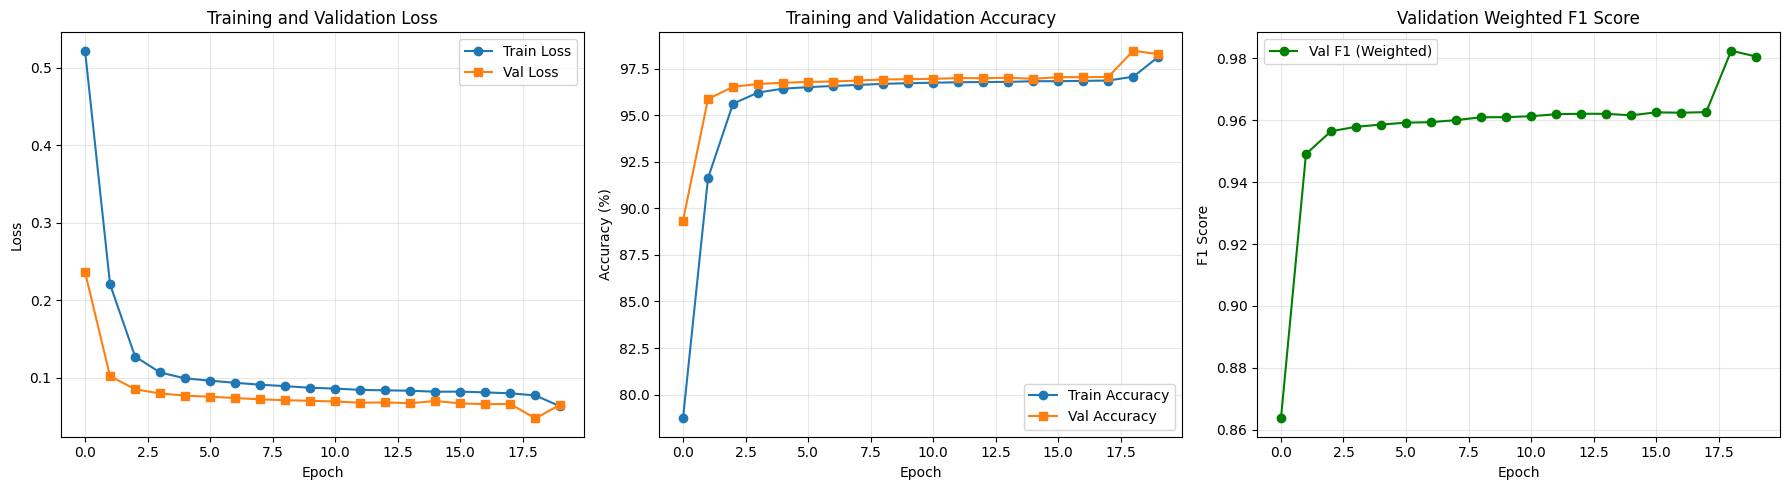

Training history plots saved as 'training_history_lstm.png'


In [21]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 Score plot
axes[2].plot(history['val_f1'], label='Val F1 (Weighted)', marker='o', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Validation Weighted F1 Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plots saved as 'training_history_lstm.png'")

In [22]:
# Load best model for evaluation
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")
print(f"Best validation F1 score: {checkpoint['val_f1']:.4f}")

Best model loaded from epoch 19
Best validation accuracy: 98.47%
Best validation F1 score: 0.9825


In [23]:
# ===== FINAL TEST EVALUATION =====
print("\n" + "="*70)
print("FINAL TEST EVALUATION ON HELD-OUT TEST SET")
print("="*70)

test_predictions = []
test_labels = []
test_total_loss = 0
test_total_samples = 0

print(f"\nEvaluating on {len(test_files)} test files...")

for test_file in tqdm(test_files, desc="Testing"):
    loss, acc, samples, preds, labels, f1 = validate_on_file(model, test_file, preprocessor)
    test_predictions.extend(preds)
    test_labels.extend(labels)
    test_total_loss += loss * samples
    test_total_samples += samples

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)

# Calculate comprehensive metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_f1_macro = f1_score(test_labels, test_predictions, average='macro', zero_division=0)
test_f1_weighted = f1_score(test_labels, test_predictions, average='weighted', zero_division=0)
test_avg_loss = test_total_loss / max(test_total_samples, 1)

print(f"\n{'='*70}")
print("TEST SET RESULTS")
print(f"{'='*70}")
print(f"  Total Test Samples: {test_total_samples:,}")
print(f"  Test Loss: {test_avg_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  Test F1-Score (Macro): {test_f1_macro:.4f}")
print(f"  Test F1-Score (Weighted): {test_f1_weighted:.4f}")
print(f"{'='*70}")


FINAL TEST EVALUATION ON HELD-OUT TEST SET

Evaluating on 26 test files...


Testing: 100%|██████████| 26/26 [02:04<00:00,  4.79s/it]




TEST SET RESULTS
  Total Test Samples: 7,057,525
  Test Loss: 0.0471
  Test Accuracy: 98.48%
  Test F1-Score (Macro): 0.6598
  Test F1-Score (Weighted): 0.9827


In [24]:
# Classification Report for Test Set
print("\n" + "="*70)
print("CLASSIFICATION REPORT (TEST SET)")
print("="*70)
class_names = preprocessor.label_encoder.classes_
print(classification_report(test_labels, test_predictions, 
                          target_names=class_names, digits=4, zero_division=0))


CLASSIFICATION REPORT (TEST SET)
                         precision    recall  f1-score   support

       Backdoor_Malware     0.0000    0.0000    0.0000       482
          BenignTraffic     0.7591    0.9818    0.8562    165827
       BrowserHijacking     0.0000    0.0000    0.0000       847
       CommandInjection     0.0000    0.0000    0.0000       802
 DDoS-ACK_Fragmentation     0.9969    0.9822    0.9895     42876
        DDoS-HTTP_Flood     0.9150    0.8946    0.9047      4354
        DDoS-ICMP_Flood     0.9995    0.9993    0.9994   1089327
DDoS-ICMP_Fragmentation     0.9721    0.9896    0.9808     68091
      DDoS-PSHACK_Flood     0.9998    0.9992    0.9995    619083
       DDoS-RSTFINFlood     0.9999    0.9990    0.9995    611897
         DDoS-SYN_Flood     0.9978    0.9960    0.9969    613209
         DDoS-SlowLoris     0.7256    0.8463    0.7813      3571
DDoS-SynonymousIP_Flood     0.9975    0.9979    0.9977    542928
         DDoS-TCP_Flood     0.9980    0.9986    0.9983 

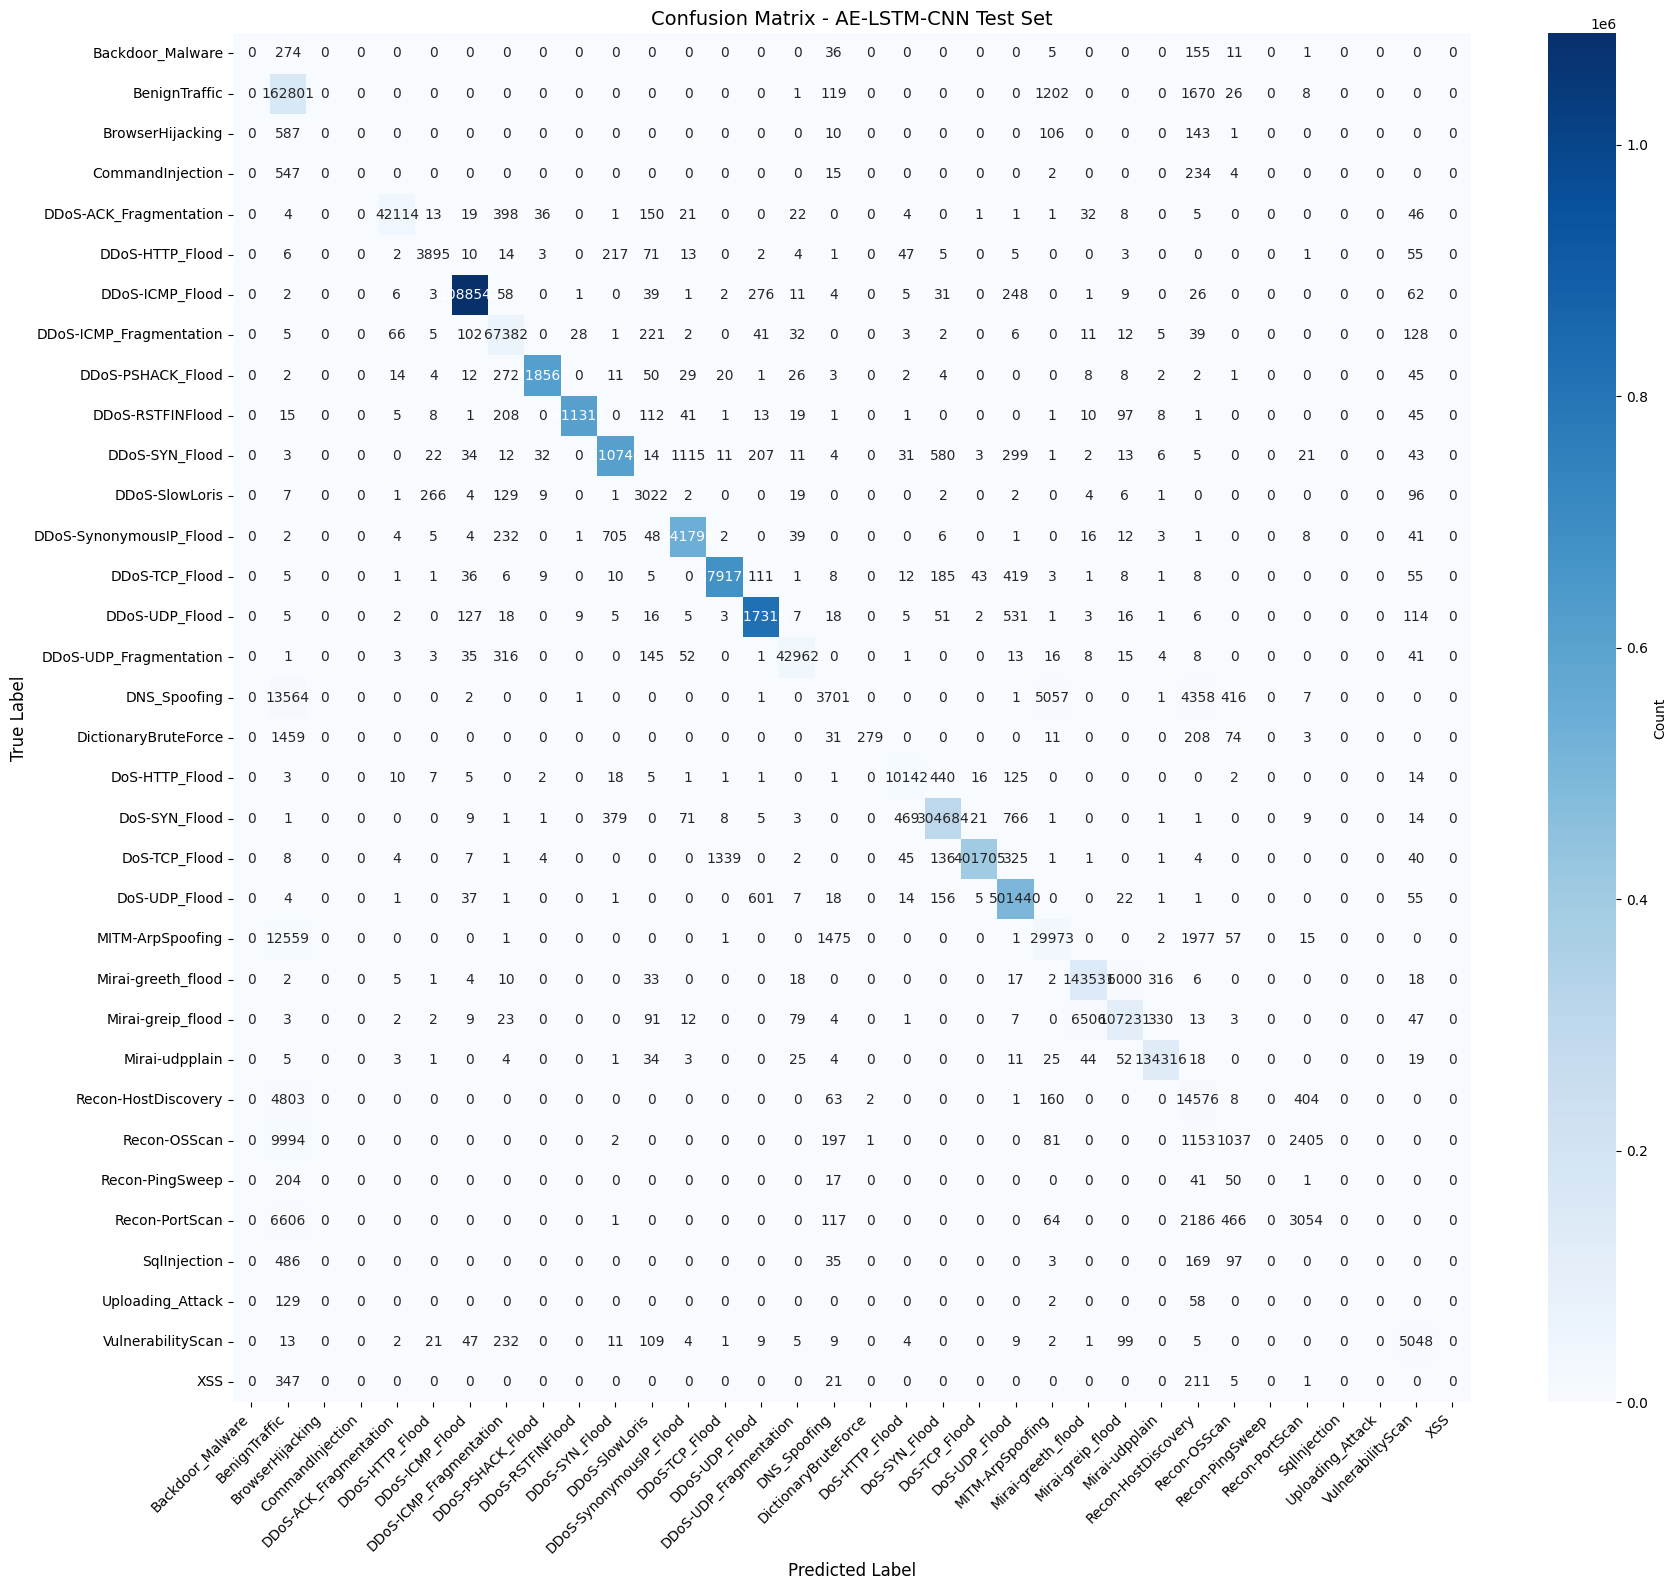

Confusion matrix saved as 'confusion_matrix_lstm_test.png'


In [25]:
# Confusion Matrix for Test Set
from sklearn.metrics import precision_recall_fscore_support

cm = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - AE-LSTM-CNN Test Set', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_lstm_test.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved as 'confusion_matrix_lstm_test.png'")


PER-CLASS PERFORMANCE (TEST SET - sorted by F1-Score)
                  Class  Precision   Recall  F1-Score  Support
      DDoS-PSHACK_Flood   0.999845 0.999167  0.999506   619083
       DDoS-RSTFINFlood   0.999935 0.999041  0.999487   611897
        DDoS-ICMP_Flood   0.999537 0.999279  0.999408  1089327
         DDoS-UDP_Flood   0.998450 0.998845  0.998647   818261
         DDoS-TCP_Flood   0.997959 0.998636  0.998297   680107
DDoS-SynonymousIP_Flood   0.997474 0.997919  0.997696   542928
          DoS-TCP_Flood   0.999774 0.995248  0.997506   403623
         DDoS-SYN_Flood   0.997772 0.995974  0.996872   613209
         Mirai-udpplain   0.994941 0.998150  0.996543   134565
          DoS-UDP_Flood   0.994471 0.998161  0.996312   502364
          DoS-SYN_Flood   0.994783 0.994257  0.994520   306444
 DDoS-ACK_Fragmentation   0.996899 0.982228  0.989509    42876
 DDoS-UDP_Fragmentation   0.992354 0.984825  0.988575    43624
DDoS-ICMP_Fragmentation   0.972071 0.989587  0.980751    68091


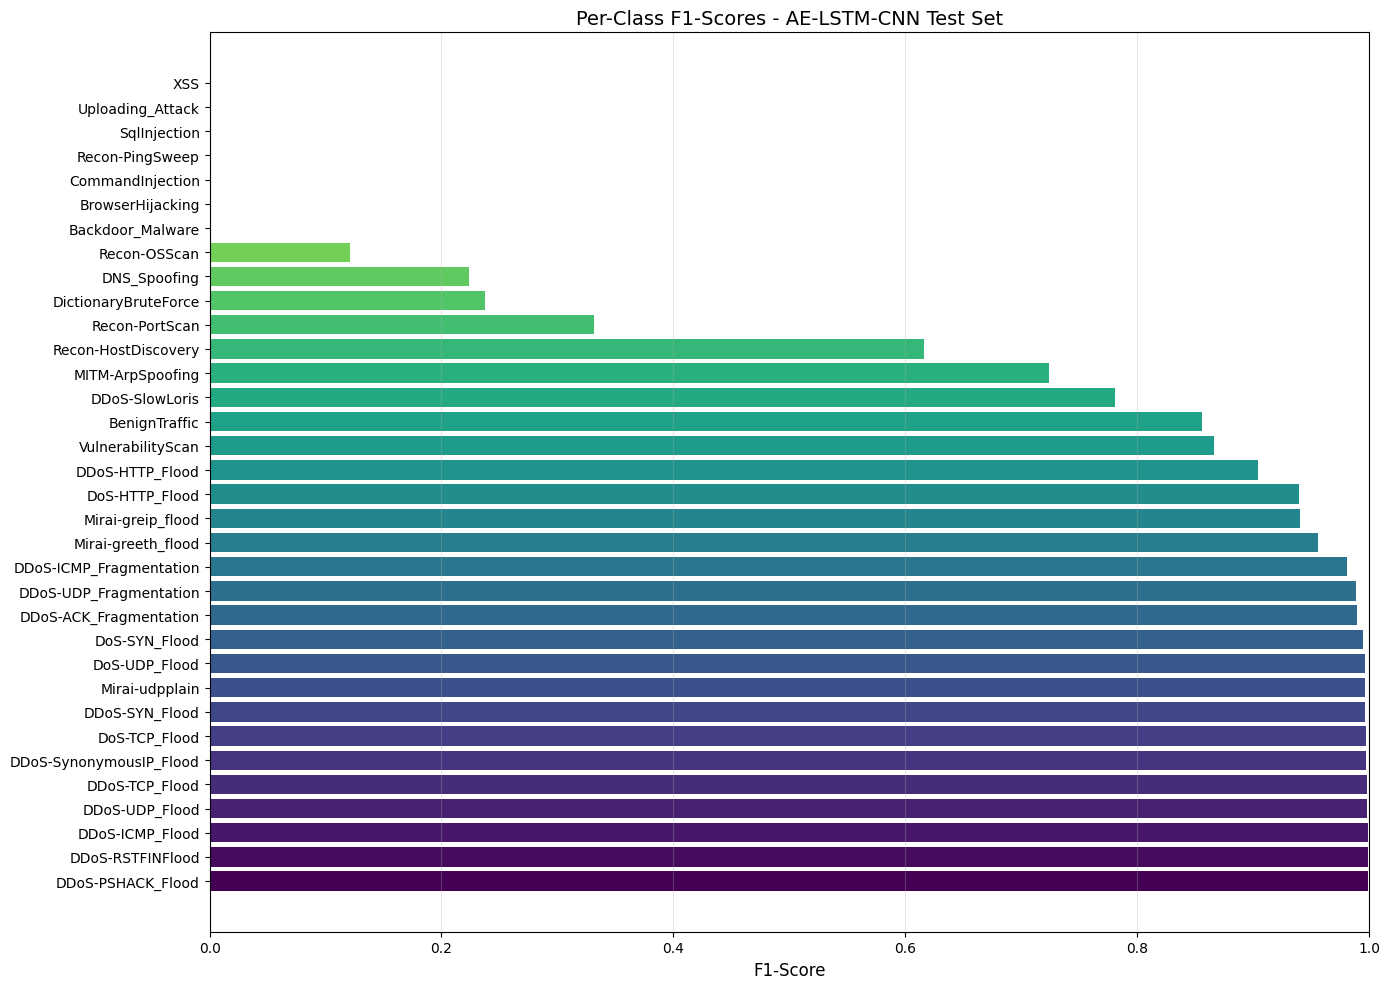

Per-class F1-scores plot saved as 'per_class_f1_scores_lstm_test.png'


In [26]:
# Per-class performance analysis for Test Set
precision, recall, f1, support = precision_recall_fscore_support(
    test_labels, test_predictions, average=None, zero_division=0
)

# Create DataFrame for better visualization
performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}).sort_values('F1-Score', ascending=False)

print("\n" + "="*70)
print("PER-CLASS PERFORMANCE (TEST SET - sorted by F1-Score)")
print("="*70)
print(performance_df.to_string(index=False))

# Plot per-class F1 scores
plt.figure(figsize=(14, 10))
colors = plt.cm.viridis(np.linspace(0, 1, len(class_names)))
bars = plt.barh(range(len(class_names)), performance_df['F1-Score'], color=colors)
plt.yticks(range(len(class_names)), performance_df['Class'])
plt.xlabel('F1-Score', fontsize=12)
plt.title('Per-Class F1-Scores - AE-LSTM-CNN Test Set', fontsize=14)
plt.xlim([0, 1.0])
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('per_class_f1_scores_lstm_test.png', dpi=300, bbox_inches='tight')
plt.show()

print("Per-class F1-scores plot saved as 'per_class_f1_scores_lstm_test.png'")

In [27]:
# Final Summary with all metrics
print("\n" + "="*70)
print("FINAL MODEL SUMMARY - AE-LSTM-CNN")
print("="*70)

print(f"\nArchitecture:")
print(f"  - Autoencoder: {NUM_FEATURES} → {ENCODER_DIM} dimensions")
print(f"  - LSTM: {LSTM_LAYERS} layers, {LSTM_HIDDEN} hidden units (bidirectional)")
print(f"  - CNN: {len(CNN_FILTERS)} layers, filters: {CNN_FILTERS}")
print(f"  - Total Parameters: {total_params:,}")

print(f"\nDataset Split:")
print(f"  - Total CSV files: {len(csv_files)}")
print(f"  - Training files: {len(train_files)} ({len(train_files)/len(csv_files)*100:.1f}%)")
print(f"  - Validation files: {len(val_files)} ({len(val_files)/len(csv_files)*100:.1f}%)")
print(f"  - Test files: {len(test_files)} ({len(test_files)/len(csv_files)*100:.1f}%)")
print(f"  - Features: {NUM_FEATURES}")
print(f"  - Classes: {NUM_CLASSES}")

print(f"\nTraining Configuration:")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Sequence Length: {SEQUENCE_LENGTH}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Chunk Size: {CHUNK_SIZE:,} rows")

print(f"\nBest Validation Performance:")
print(f"  - Val Accuracy: {best_val_acc:.2f}%")
print(f"  - Val F1 (Weighted): {best_val_f1:.4f}")

print(f"\nFinal Test Performance:")
print(f"  - Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  - Test F1 (Macro): {test_f1_macro:.4f}")
print(f"  - Test F1 (Weighted): {test_f1_weighted:.4f}")

print(f"\nModel saved as: {MODEL_SAVE_PATH}")
print("="*70)


FINAL MODEL SUMMARY - AE-LSTM-CNN

Architecture:
  - Autoencoder: 46 → 32 dimensions
  - LSTM: 2 layers, 64 hidden units (bidirectional)
  - CNN: 3 layers, filters: [64, 128, 256]
  - Total Parameters: 434,096

Dataset Split:
  - Total CSV files: 169
  - Training files: 117 (69.2%)
  - Validation files: 26 (15.4%)
  - Test files: 26 (15.4%)
  - Features: 46
  - Classes: 34

Training Configuration:
  - Epochs: 20
  - Batch Size: 20480
  - Sequence Length: 10
  - Learning Rate: 0.001
  - Chunk Size: 500,000 rows

Best Validation Performance:
  - Val Accuracy: 98.47%
  - Val F1 (Weighted): 0.9825

Final Test Performance:
  - Test Accuracy: 98.48%
  - Test F1 (Macro): 0.6598
  - Test F1 (Weighted): 0.9827

Model saved as: best_ae_lstm_cnn_optimized.pth


In [ ]:
# Load best model for evaluation
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

In [30]:
# Comprehensive evaluation on validation set
print("\n" + "="*70)
print("Comprehensive Evaluation on Validation Set")
print("="*70)

all_val_predictions = []
all_val_labels = []

for val_file in tqdm(val_files, desc="Evaluating"):
    _, _, _, predictions, labels, _ = validate_on_file(model, val_file, preprocessor)

    all_val_predictions.extend(predictions)
    all_val_labels.extend(labels)

all_val_predictions = np.array(all_val_predictions)
all_val_labels = np.array(all_val_labels)

# Calculate metrics
accuracy = accuracy_score(all_val_labels, all_val_predictions)
f1_macro = f1_score(all_val_labels, all_val_predictions, average='macro')
f1_weighted = f1_score(all_val_labels, all_val_predictions, average='weighted')

print(f"\nOverall Metrics:")
print(f"  Accuracy: {accuracy*100:.2f}%")
print(f"  F1-Score (Macro): {f1_macro:.4f}")
print(f"  F1-Score (Weighted): {f1_weighted:.4f}")

# Classification report
print(f"\n{'='*70}")
print("Classification Report:")
print(f"{'='*70}")
class_names = preprocessor.label_encoder.classes_
print(classification_report(all_val_labels, all_val_predictions, 
                          target_names=class_names, digits=4))


Comprehensive Evaluation on Validation Set


Evaluating: 100%|██████████| 26/26 [02:53<00:00,  6.66s/it]




Overall Metrics:
  Accuracy: 98.47%
  F1-Score (Macro): 0.6604
  F1-Score (Weighted): 0.9825

Classification Report:
                         precision    recall  f1-score   support

       Backdoor_Malware     0.0000    0.0000    0.0000       490
          BenignTraffic     0.7570    0.9817    0.8548    166008
       BrowserHijacking     0.0000    0.0000    0.0000       940
       CommandInjection     0.0000    0.0000    0.0000       843
 DDoS-ACK_Fragmentation     0.9972    0.9823    0.9897     43144
        DDoS-HTTP_Flood     0.9219    0.9082    0.9150      4445
        DDoS-ICMP_Flood     0.9995    0.9993    0.9994   1087055
DDoS-ICMP_Fragmentation     0.9731    0.9900    0.9815     68713
      DDoS-PSHACK_Flood     0.9999    0.9992    0.9995    619037
       DDoS-RSTFINFlood     0.9999    0.9991    0.9995    610911
         DDoS-SYN_Flood     0.9977    0.9961    0.9969    613768
         DDoS-SlowLoris     0.7290    0.8385    0.7800      3555
DDoS-SynonymousIP_Flood     0.9975  

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_val_labels, all_val_predictions)

# Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - AE-LSTM-CNN Intrusion Detection', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved as 'confusion_matrix.png'")

In [ ]:
# Per-class performance analysis
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    all_val_labels, all_val_predictions, average=None
)

# Create DataFrame for better visualization
performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}).sort_values('F1-Score', ascending=False)

print("\nPer-Class Performance (sorted by F1-Score):")
print(performance_df.to_string(index=False))

# Plot per-class F1 scores
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(class_names)))
bars = plt.barh(range(len(class_names)), performance_df['F1-Score'], color=colors)
plt.yticks(range(len(class_names)), performance_df['Class'])
plt.xlabel('F1-Score', fontsize=12)
plt.title('Per-Class F1-Scores - AE-LSTM-CNN Model', fontsize=14)
plt.xlim([0, 1.0])
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('per_class_f1_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("Per-class F1-scores plot saved as 'per_class_f1_scores.png'")

In [ ]:
# Model summary and final statistics
print("\n" + "="*70)
print("Final Model Summary")
print("="*70)
print(f"\nArchitecture: AE-LSTM-CNN Hybrid")
print(f"  - Autoencoder: {NUM_FEATURES} → {ENCODER_DIM} dimensions")
print(f"  - LSTM: {LSTM_LAYERS} layers, {LSTM_HIDDEN} hidden units (bidirectional)")
print(f"  - CNN: {len(CNN_FILTERS)} layers, filters: {CNN_FILTERS}")
print(f"  - Total Parameters: {total_params:,}")
print(f"\nDataset:")
print(f"  - Total CSV files: {len(csv_files)}")
print(f"  - Training files: {len(train_files)}")
print(f"  - Validation files: {len(val_files)}")
print(f"  - Features: {NUM_FEATURES}")
print(f"  - Classes: {NUM_CLASSES}")
print(f"\nTraining Configuration:")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Sequence Length: {SEQUENCE_LENGTH}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Gradient Accumulation: {ACCUMULATION_STEPS} steps")
print(f"  - Chunk Size: {CHUNK_SIZE:,} rows")
print(f"\nFinal Performance:")
print(f"  - Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  - Final F1-Score (Macro): {f1_macro:.4f}")
print(f"  - Final F1-Score (Weighted): {f1_weighted:.4f}")
print(f"\nModel saved as: {MODEL_SAVE_PATH}")
print("="*70)

In [ ]:
# Save preprocessor for future use
import pickle

with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

print("Preprocessor saved as 'preprocessor.pkl'")
print("\nTo use this model for inference:")
print("1. Load the preprocessor: preprocessor = pickle.load(open('preprocessor.pkl', 'rb'))")
print("2. Load the model: model.load_state_dict(torch.load('best_ae_lstm_cnn_optimized.pth')['model_state_dict'])")
print("3. Preprocess new data and make predictions")